# Signate開始時のお約束

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

auth.authenticate_user()

drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'signate.json'", fields="files(id)").execute()
signate_api_key = results.get('files', [])

filename = "/root/.signate/signate.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)

request = drive_service.files().get_media(fileId=signate_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

Download 100%.


In [3]:
!pip install signate

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=fab53d3fb71de8ceb24b7def7895b5898618e38ec563bbac1a2a0ed8b02fc506
  Stored in directory: /root/.cache/pip/wheels/40/b3/0f/a40dbd1c6861731779f62cc4babcb234387e11d697df70ee97
Successfully built wget


In [4]:
!signate files --competition-id=1523

  fileId  name               title                     size  updated_at
--------  -----------------  ----------------------  ------  -------------------
    3939  train.csv          学習用データ            494008  2024-08-01 12:00:28
    3940  test.csv           評価用データ            488363  2024-08-01 12:00:38
    3944  sample_submit.csv  応募用サンプルファイル   86893  2024-08-01 12:00:49
    4057  tutorial.ipynb     チュートリアルコード    323126  2024-08-01 12:01:00


In [5]:
!signate download --competition-id=1523

sample_submit.csv

tutorial.ipynb

test.csv

train.csv


Download completed.


In [6]:
!pip install kanjize

In [7]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 17.7 MB/s eta 0:00:00


In [8]:
# ライブラリのインポート
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# データフレーム読み込み
train_df = pd.read_csv("/content/train.csv")
test_df = pd.read_csv("/content/test.csv")

In [978]:
# データ結合(番号を振り直す)
all_df = pd.concat([train_df,test_df],axis=0,ignore_index=True)
max_row = len(all_df)

<ipython-input-979-48fbc04d19be>:42: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  all_df["Age"] = all_df["Age"].replace(-1,all_df.loc[all_df["Age"]>0,"Age"].median())


<Axes: >

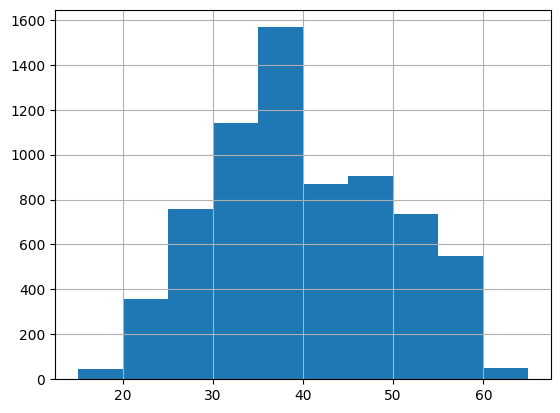

In [979]:
###############
# "Age"の処理 #
###############
import unicodedata # 全角を半角に変換
from kanjize import kanji2number # 漢字を数値に変換
import re

# 漢字の判定用
p = re.compile('[一二三四五六七八九十]+')

# nanを-1歳で補完
all_df["Age"] = all_df["Age"].fillna("-1歳")

# Ageの処理
for i in range(max_row):

  # 末尾文字の取得
  tail = all_df.loc[i,"Age"][-1:]

  # 先頭文字が漢字の場合
  if(p.search(all_df.loc[i,"Age"][0])!=None):
    tmp = all_df.loc[i,"Age"][:-1]
    all_df.loc[i,"Age"] = kanji2number(tmp)
    all_df.loc[i,"Age"] = int(all_df.loc[i,"Age"])

  # 末尾文字が歳、才、際の場合
  elif((tail=="歳")or(tail=="才")or(tail=="際")):
    all_df.loc[i,"Age"] = all_df.loc[i,"Age"][:-1]
    # 全角を半角に直す
    all_df.loc[i,"Age"] = unicodedata.normalize("NFKC", all_df.loc[i,"Age"])
    all_df.loc[i,"Age"] = int(all_df.loc[i,"Age"])

  # 代の場合
  elif(tail == "代"):
    tmp = all_df.loc[i,"Age"][:-1]
    # 数値変換し5足す
    tmp = int(tmp)
    all_df.loc[i,"Age"] = tmp + 5
    all_df.loc[i,"Age"] = int(all_df.loc[i,"Age"])

# 「-1」はそれ以外の中央値を代入
all_df["Age"] = all_df["Age"].replace(-1,all_df.loc[all_df["Age"]>0,"Age"].median())

# int型にキャストする
all_df["Age"] = all_df["Age"].astype(int)

# ヒストグラムを描く
all_df["Age"].hist()

In [980]:
#########################
# "TypeofContact"の処理 #
#########################
all_df["TypeofContact"] = all_df["TypeofContact"].fillna("Self Enquiry")
all_df["TypeofContact"].value_counts()

,count
TypeofContact,
Self Enquiry,4462
Company Invited,2516


In [981]:
#########################
# "CityTier"の処理 #
#########################
all_df["CityTier"].value_counts()

,count
CityTier,
2,3160
1,2991
3,827


<Axes: >

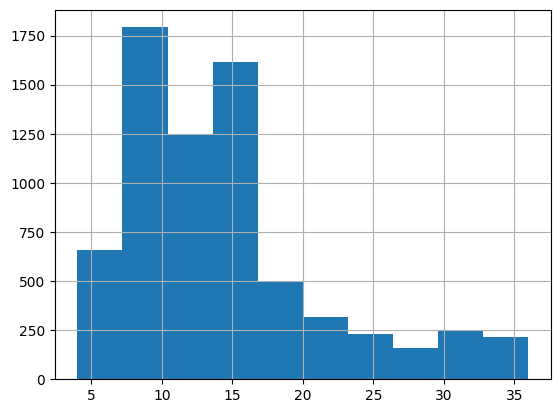

In [982]:
#########################
# "DurationOfPitch"の処理 #
#########################
# nanを-1分で補完
all_df["DurationOfPitch"] = all_df["DurationOfPitch"].fillna("-1分")

# 秒を分に変換 #
for i in range(max_row):

  tail = str(all_df.loc[i,"DurationOfPitch"])[-1:]

  if(tail == "秒"):
    tmp = all_df.loc[i,"DurationOfPitch"][:-1]
    all_df.loc[i,"DurationOfPitch"] = float(tmp) / 60.0
  elif(tail == "分"):
    all_df.loc[i,"DurationOfPitch"] = all_df.loc[i,"DurationOfPitch"][:-1]

all_df["DurationOfPitch"] = all_df["DurationOfPitch"].astype("float64")

# 「-1」はそれ以外の中央値を代入
all_df["DurationOfPitch"] = all_df["DurationOfPitch"].replace(-1,all_df.loc[all_df["DurationOfPitch"]>0,"DurationOfPitch"].median())

# 分布の確認
all_df["DurationOfPitch"].hist()

In [983]:
####################
# "Occupation"の処理 #
####################
all_df["Occupation"].value_counts()

,count
Occupation,
Small Business,3456
Salaried,2801
Large Business,721


In [984]:
##################
# "Genger"の処理 #
##################
# 先頭文字がMかmならMaleになる
for i in range(max_row):

  # 先頭文字の取得(半角)
  head = unicodedata.normalize("NFKC", all_df.loc[i,"Gender"][:1])
  if(head == "m"):
    all_df.loc[i,"Gender"] = "Male"
  else:
    all_df.loc[i,"Gender"] = "Female"

# 分類の確認
all_df["Gender"].value_counts()

,count
Gender,
Female,5946
Male,1032


In [985]:
##################################
# "NumberOfPersonVisiting"の処理 #
##################################
all_df["NumberOfPersonVisiting"].value_counts()

,count
NumberOfPersonVisiting,
2.0,3163
3.0,2773
1.0,686
4.0,356


In [986]:
##################################
# "NumberOfFollowups"の処理 #
##################################

# 欠損を-1で埋めてから中央値を取る
all_df["NumberOfFollowups"] = all_df["NumberOfFollowups"].fillna(-1)
all_df["NumberOfFollowups"] = all_df["NumberOfFollowups"].replace(-1,all_df.loc[all_df["NumberOfFollowups"]>0,"NumberOfFollowups"].median())

# 100回以上は記録違いとして100で割る
all_df.loc[all_df["NumberOfFollowups"]>=100,"NumberOfFollowups"] = all_df.loc[all_df["NumberOfFollowups"]>=100,"NumberOfFollowups"] / 100

# 分布の確認
all_df["NumberOfFollowups"].value_counts()

,count
NumberOfFollowups,
4.0,2834
3.0,2561
5.0,1122
2.0,213
1.0,178
6.0,70


In [987]:
##########################
# "ProductPitched"の処理 #
##########################

# ギリシャ文字をアルファベットに変換
greek_string = "αβγδεζηθικλμνξοπρστυφχψωвꓢѕꭰտᗞı𐊡"
alphabet_string = "abgdezhqiklmnxoprstufcywbssdsdib"

def greek_to_alphabet(text):
    result = ""
    for char in text:
        if char in greek_string:
            result += alphabet_string[greek_string.index(char)]
        else:
            result += char  # ギリシャ文字以外の文字はそのまま
    return result

# Basic, Standard, Deluxe, Super Deluxe, kingに分ける
prefix = 0
others = []
# すべて小文字に変換し判定
for i in range(len(all_df)):
  prefix = unicodedata.normalize("NFKC", greek_to_alphabet(all_df.loc[i,"ProductPitched"][:2].lower())).lower()

  if(prefix == "ba"):
    all_df.loc[i,"ProductPitched"] = "Basic"

  elif(prefix == "st"):
    all_df.loc[i,"ProductPitched"] = "Standard"

  elif(prefix == "de"):
    all_df.loc[i,"ProductPitched"] = "Deluxe"

  elif(prefix == "su"):
    all_df.loc[i,"ProductPitched"] = "SuperDeluxe"

  elif(prefix == "ki"):
    all_df.loc[i,"ProductPitched"] = "King"

  else:
    others.append(i)

# 分布の確認
all_df["ProductPitched"].value_counts()

,count
ProductPitched,
Basic,2347
Deluxe,2091
Standard,1614
SuperDeluxe,640
King,286


In [988]:
#################################
# "PreferredPropertyStar"の処理 #
#################################
all_df["PreferredPropertyStar"].value_counts()

,count
PreferredPropertyStar,
3.0,4328
4.0,2254
5.0,396


<Axes: >

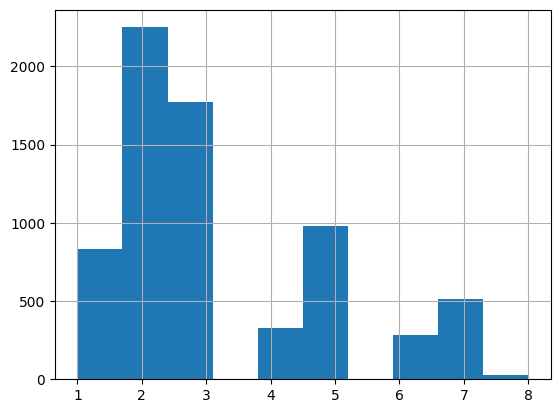

In [989]:
#########################
# "NumberOfTrips"の処理 #
#########################
# nanは-1で補完
all_df["NumberOfTrips"] = all_df["NumberOfTrips"].fillna("-1")

# 一旦オブジェクト型に変更
all_df["NumberOfTrips"] = all_df["NumberOfTrips"].astype("object")

for i in range(max_row):

  # 先頭文字の取得(半角)
  head = all_df.loc[i,"NumberOfTrips"][:1]

  if(head == "年"):
    all_df.loc[i,"NumberOfTrips"] = all_df.loc[i,"NumberOfTrips"][2:3]

  elif(head == "半"):
    all_df.loc[i,"NumberOfTrips"] = all_df.loc[i,"NumberOfTrips"][3:4]

  elif(head == "四"):
    all_df.loc[i,"NumberOfTrips"] = all_df.loc[i,"NumberOfTrips"][4:5]

# int型に変更
all_df["NumberOfTrips"] = all_df["NumberOfTrips"].astype("int")

# 「-1」はそれ以外の中央値を代入
all_df["NumberOfTrips"] = all_df["NumberOfTrips"].replace(-1,all_df.loc[all_df["NumberOfTrips"]>0,"NumberOfTrips"].median())

# ヒストグラムの確認
all_df["NumberOfTrips"].hist()

In [990]:
#########################
# "Passport"の処理 #
#########################
all_df["Passport"].value_counts()

,count
Passport,
0,6288
1,690


<Axes: >

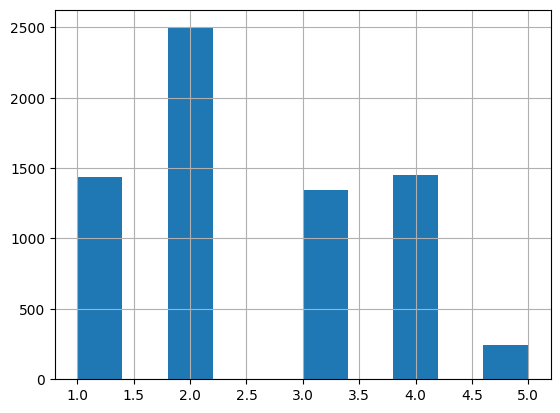

In [991]:
##################################
# "PitchSatisfactionScore"の処理 #
##################################
all_df["PitchSatisfactionScore"].hist()

In [992]:
#########################
# "Designation"の処理 #
#########################

# ギリシャ文字をアルファベットに変換
greek_string = "αβγδεζηθικλμνξοπρστυφχψωвꓢѕꭰտᗞı𐊡Аае"
alphabet_string = "abgdezhqiklmnxoprstufcywbssdsdibaae"

def greek_to_alphabet(text):
    result = ""
    for char in text:
        if char in greek_string:
            result += alphabet_string[greek_string.index(char)]
        else:
            result += char  # ギリシャ文字以外の文字はそのまま
    return result

In [993]:
# 文字を変換する
prefix = 0
for i in range(len(all_df)):
  prefix = unicodedata.normalize("NFKC", greek_to_alphabet(all_df.loc[i,"Designation"][:1].lower())).lower()

  # Executive: 取締役、執行役員
  if(prefix == "e"):
    all_df.loc[i,"Designation"] = "Executive"

  # Vice President: 本部長
  elif(prefix == "v"):
    all_df.loc[i,"Designation"] = "VP"

  # Associate Vice President: 本部長補佐
  elif(prefix == "a"):
    all_df.loc[i,"Designation"] = "AVP"

  # Senior Manager: 次長
  elif(prefix == "s"):
    all_df.loc[i,"Designation"] = "Senior Manager"

  # Manager: 課長
  elif(prefix == "m"):
    all_df.loc[i,"Designation"] = "Manager"

# 分類の確認
all_df["Designation"].value_counts()

,count
Designation,
Executive,2330
Manager,2117
Senior Manager,1632
AVP,635
VP,264


<Axes: >

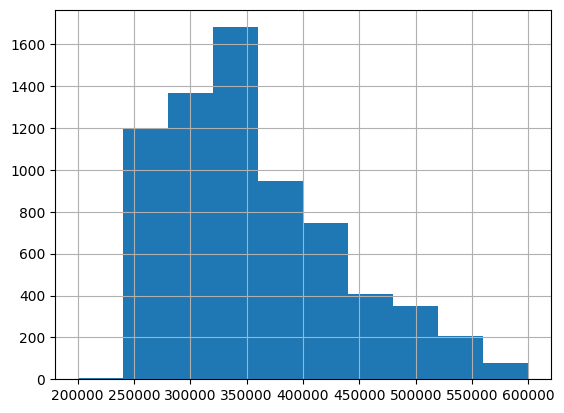

In [994]:
#########################
# "MonthlyIncome"の処理 #
#########################
import re

# 漢字の判定用
p = re.compile('[月]+')

# nanを-1で補完
all_df["MonthlyIncome"] = all_df["MonthlyIncome"].fillna("-1")

for i in range(max_row):

  # 先頭文字の取得
  head = all_df.loc[i,"MonthlyIncome"][:1]

  # 先頭文字が漢字の場合
  if(p.search(head[0])!=None):
    tmp = all_df.loc[i,"MonthlyIncome"][2:-2]
    all_df.loc[i,"MonthlyIncome"] = float(tmp)*10000

# float型にキャストする
all_df["MonthlyIncome"] = all_df["MonthlyIncome"].astype(float)

# 「-1」はそれ以外の中央値を代入
all_df["MonthlyIncome"] = all_df["MonthlyIncome"].replace(-1,all_df.loc[all_df["MonthlyIncome"]>0,"MonthlyIncome"].median())

# 分布の確認
all_df["MonthlyIncome"].hist()

In [995]:
#########################
# "customer_info"の処理 #
#########################
import re

# 項目名
cont = []

# 区切り文字で分割する
for i in range(max_row):
  tmp = re.split("[ 　,、\n\t/／\u3000]",all_df.loc[i,"customer_info"])
  tmp = list(filter(None, tmp))
  if(type(tmp)==list):
    for j in range(len(tmp)):
      if(tmp[j] not in cont):
        cont.append(tmp[j])

# キーワード抽出
c_car = [] # 車関係
c_child = [] # 子供関係
c_married = [] # 婚姻関係
c_other = [] # その他

for i in range(len(cont)):
  # 「車あり」、「車所持」、「自家用車あり」、「車保有」、「乗用車所持」、「自動車保有」
  # 「車なし」、「車未所持」、「自家用車なし」、「車保有なし」、「乗用車なし」、「自動車未所有」
  if((cont[i][0:1] == "車") or (cont[i][0:1] == "自") or (cont[i][0:1] == "乗")):
    c_car.append(cont[i])
  # 「こども1人」、「1児」、「子供1人」、「子供有り(1人)」、「子供有り」
  # 「こども2人」、「2児」、「子供2人」、「子供有り(2人)」
  # 「こども3人」、「3児」「子供3人」、「子供有り(3人)」
  # 「子供なし」、「子供無し」、「無子」、「子供ゼロ」、「非児童家庭」
  # 「子育て状況不明」、「子の数不詳」、「子供の数不明」
  elif((cont[i][0:1] == "子") or (cont[i][0:1] == "こ") or (cont[i][-1:] == "児") or (cont[i][-1:] == "子") or (cont[i][-1:] == "庭")):
    c_child.append(cont[i])
  # 「結婚済み」、「離婚済み」、「未婚」、「独身」
  elif((cont[i][0:1] == "結") or (cont[i][0:1] == "離") or (cont[i][0:1] == "独") or (cont[i][0:1] == "離") or (cont[i][0:1] == "未")):
    c_married.append(cont[i])
  # 「1人」、「2人」、「3人」、「不明」、「わからない」
  else:
    c_other.append(cont[i])

In [996]:
# 新たなカラムを追加
all_df["CarHolder"] = 0 # 車所有
all_df["NumofChild"] = 0 # 子供の数
all_df["Married"] = "Single" # 婚姻歴

# 車
c_car_hold = ["車あり","車所持","自家用車あり","車保有","乗用車所持","自動車保有"]

# 子供
c_child_1 = ["こども1人","1児""子供1人","子供有り(1人)","子供有り"]
c_child_2 = ["こども2人","2児""子供2人","子供有り(2人)"]
c_child_3 = ["こども3人","3児""子供3人","子供有り(3人)"]

# 婚姻状況
c_pair = ["結婚済み"]
c_batu = ["離婚済み"]

# 区切り文字で分割する
for i in range(max_row):
  tmp = re.split("[ 　,、\n\t/／\u3000]",all_df.loc[i,"customer_info"])
  tmp = list(filter(None, tmp))
  if(type(tmp)==list):
    for j in range(len(tmp)):
      # 車の情報
      if(tmp[j] in c_car_hold):
        all_df.loc[i, "CarHolder"] = 1
      # 子供の情報
      if(tmp[j] in c_child_1):
        all_df.loc[i, "NumofChild"] = 1
      if(tmp[j] in c_child_2):
        all_df.loc[i, "NumofChild"] = 2
      if(tmp[j] in c_child_3):
        all_df.loc[i, "NumofChild"] = 3
      # 婚姻歴
      if(tmp[j] in c_pair):
        all_df.loc[i, "Married"] = "Married"
      if(tmp[j] in c_batu):
        all_df.loc[i, "Married"] = "Divorce"

# 使用済みカラム抹消
all_df = all_df.drop("customer_info", axis=1)

In [997]:
# 車保有率
all_df["CarHolder"].value_counts()

,count
CarHolder,
0,4408
1,2570


In [998]:
# 子供の数
all_df["NumofChild"].value_counts()

,count
NumofChild,
0,5015
1,1347
2,571
3,45


In [999]:
# 婚姻歴
all_df["Married"].value_counts()

,count
Married,
Married,2846
Single,2444
Divorce,1688


# 特徴量エンジニアリング

In [1000]:
# 「Dsignation」をラベルエンコード
all_df["Designation_LE"] = 1
all_df.loc[all_df["Designation"]=="Executive","Designation_LE"] = 5
all_df.loc[all_df["Designation"]=="VP","Designation_LE"] = 4
all_df.loc[all_df["Designation"]=="AVP","Designation_LE"] = 3
all_df.loc[all_df["Designation"]=="Senior Manager","Designation_LE"] = 2
all_df.loc[all_df["Designation"]=="Manager","Designation_LE"] = 1
all_df = all_df.drop("Designation", axis=1)

# 「Occupation」をラベルエンコード
all_df["Occupation_LE"] = 1
all_df.loc[all_df["Occupation"]=="Large Business","Occupation_LE"] = 3
all_df.loc[all_df["Occupation"]=="Small Business","Occupation_LE"] = 2
all_df.loc[all_df["Occupation"]=="Salaried","Occupation_LE"] = 1
all_df = all_df.drop("Occupation", axis=1)

# 「CarHolder」をラベルエンコード
all_df["CarHolder_LE"] = all_df["CarHolder"] + 1
all_df = all_df.drop("CarHolder", axis=1)

# 「Gender」をラベルエンコード
all_df["Gender_LE"] = 1
all_df.loc[all_df["Gender"]=="Female","Gender_LE"]=2
all_df.loc[all_df["Gender"]=="Male","Gender_LE"]=2
all_df = all_df.drop("Gender", axis=1)

# 「ProductPitched」をラベルエンコード
all_df["ProductPitched_LE"] = 1
all_df.loc[all_df["ProductPitched"]=="King","ProductPitched_LE"]=5
all_df.loc[all_df["ProductPitched"]=="SuperDeluxe","ProductPitched_LE"]=4
all_df.loc[all_df["ProductPitched"]=="Deluxe","ProductPitched_LE"]=3
all_df.loc[all_df["ProductPitched"]=="Standard","ProductPitched_LE"]=2
all_df.loc[all_df["ProductPitched"]=="Basic","ProductPitched_LE"]=1
all_df = all_df.drop("ProductPitched", axis=1)

# 「Married」をラベルエンコード
all_df["Married_LE"] = 1
all_df.loc[all_df["Married"]=="Married","Married_LE"]=3
all_df.loc[all_df["Married"]=="Divorce","Married_LE"]=2
all_df.loc[all_df["Married"]=="Single","Married_LE"]=1
all_df = all_df.drop("Married", axis=1)

# 「TypeofContact」をラベルエンコード
all_df["TypeofContact_LE"] = 1
all_df.loc[all_df["TypeofContact"]=="Company Invited","TypeofContact_LE"]=2
all_df.loc[all_df["TypeofContact"]=="Self Enquiry","TypeofContact_LE"]=1
all_df = all_df.drop("TypeofContact", axis=1)

In [1001]:
# 検討の結果、重要度が低いものを抹消する
# Occupation_LE, NumberOfFollowups, PreferredPropertyStar,Gender_LE
all_df = all_df.drop("Occupation_LE", axis=1)
all_df = all_df.drop("NumberOfFollowups", axis=1)
all_df = all_df.drop("PreferredPropertyStar", axis=1)
all_df = all_df.drop("Gender_LE", axis=1)

In [1002]:
# クロス特徴量
# 「役職」x「商品ランク」
all_df["Designation_ProductPitched"] = all_df["Designation_LE"] * all_df["ProductPitched_LE"]

In [1003]:
# 月収、年齢はLogを取る
all_df["MonthlyIncomeLOG"] = np.log1p(all_df["MonthlyIncome"])
all_df["AgeLOG"] = np.log1p(all_df["Age"])

# 元の列削除
all_df = all_df.drop("Age", axis=1)
all_df = all_df.drop("MonthlyIncome", axis=1)

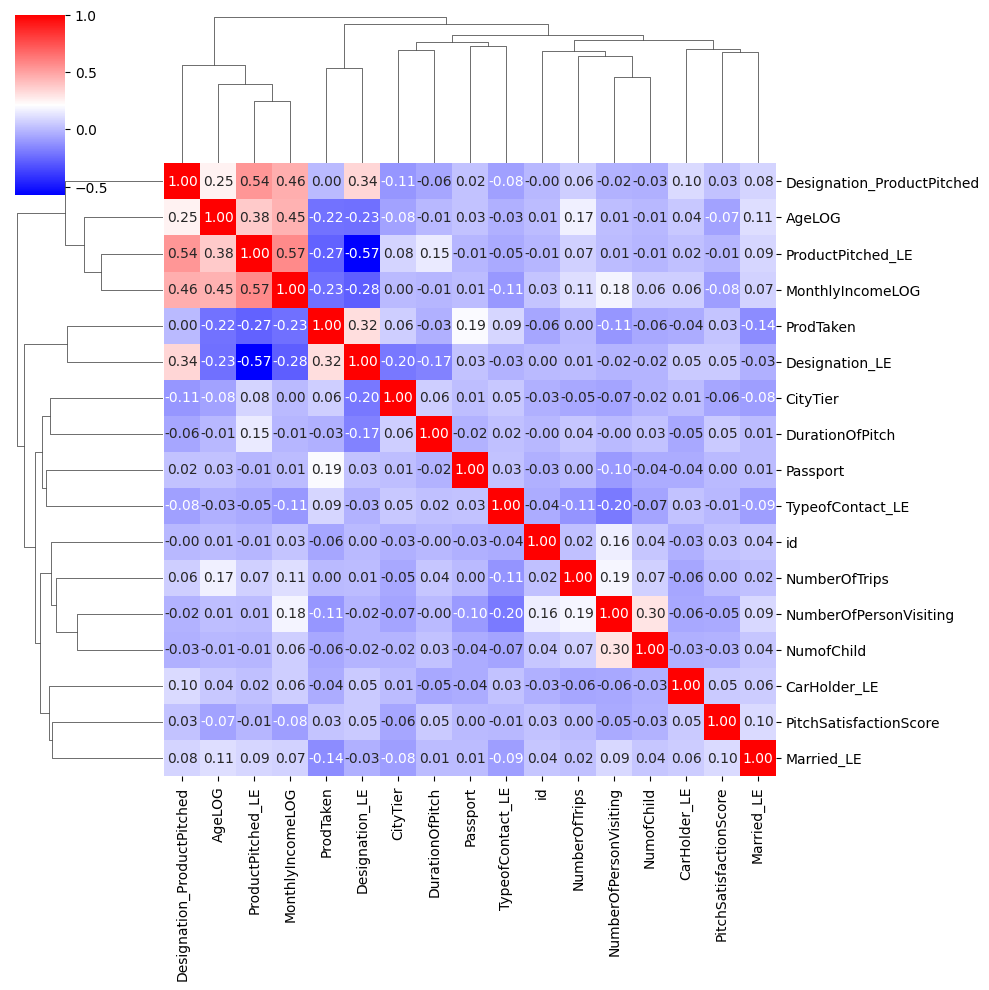

In [1004]:
import seaborn as sns
import matplotlib.pyplot as plt

all_df_corr = all_df.corr()

# sns.heatmap(all_df_corr,annot=True,cmap="bwr")
# sns.heatmap(all_df_corr,annot=False,cmap="bwr")
# plt.show()
sns.clustermap(all_df_corr,annot=True,fmt=".2f",cmap="bwr")
plt.show()

# ここから学習作業

In [1005]:
# 取り除く変数
RMV = ["id","ProdTaken"]
RMV2 = ["id"]

FEATURES = [c for c in all_df.columns if c not in RMV2]
TARGET = "ProdTaken"

In [1006]:
CATS = []
for c in FEATURES:
  if all_df[c].dtype == "object":
    CATS.append(c)

In [1007]:
# カラムを制限
all_df2 = all_df[FEATURES]

# 結合を戻す
train = all_df2.iloc[:len(train_df)].copy()
test = all_df2.iloc[len(train_df):].reset_index(drop=True).copy()

# 対象の列のみ取り込み
test = test.drop(TARGET,axis=1)
FEATURES = test.columns

In [1008]:
# Optunaを使用する
import optuna
import lightgbm as lgb
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import KFold # K分割
import lightgbm as lgb
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GroupKFold

oof_lgb = np.zeros(len(train))
pred_lgb = np.zeros(len(test))
models = []
evaluations_result = {}

FOLDS = 3 # 分割数
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=26)

def objective(trial):

  lgbm_params = {
      'objective': 'binary',
      "device": "cpu",
      'metric': 'auc',
      'verbose': -1,              # ログ出力の制御
      'boosting_type': 'gbdt',
      'learning_rate': 0.1,

      'num_leaves': trial.suggest_int('num_leaves', 16, 256),
      'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 100),
      'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
      'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1),
      'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
      'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0,log=True),
      'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0,log=True),
      'max_depth': trial.suggest_int('max_depth', 3, 12),

      # 'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
      }

  for i, (train_index, test_index) in enumerate(skf.split(train, train[TARGET])):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)

    # インデックスに割り振る

    x_train = train.loc[train_index, FEATURES].copy()
    y_train = train.loc[train_index, TARGET]
    x_valid = train.loc[test_index, FEATURES].copy()
    y_valid = train.loc[test_index, TARGET]
    # x_test = test[FEATURES].copy()

    # データセット作成
    lgb_train = lgb.Dataset(x_train, y_train)
    lgb_eval = lgb.Dataset(x_valid, y_valid, reference = lgb_train)

    # 学習
    model_lgb = lgb.train(lgbm_params,
                          lgb_train,
                          num_boost_round = 2000,
                          valid_sets = [lgb_train, lgb_eval],
                          valid_names = ["train", "valid"],
                          callbacks = [
                              lgb.early_stopping(stopping_rounds=100, verbose=False),
                              # lgb.record_evaluation(evaluations_result),
                              lgb.log_evaluation(100),])

    oof_lgb[test_index] = model_lgb.predict(x_valid, num_iteration = model_lgb.best_iteration)

  score = roc_auc_score(train[TARGET],oof_lgb)

  return score

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

[I 2025-05-24 11:19:17,454] A new study created in memory with name: no-name-b93bd2be-ee55-4723-8293-2ac98cfdc8cd
<ipython-input-1008-0e9e471f93a1>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.882109	valid's auc: 0.827307
#########################
### Fold 2
#########################
[100]	train's auc: 0.874719	valid's auc: 0.850183
#########################
### Fold 3
#########################
[100]	train's auc: 0.889631	valid's auc: 0.813324


[I 2025-05-24 11:19:18,107] Trial 0 finished with value: 0.8272664059221639 and parameters: {'num_leaves': 45, 'min_data_in_leaf': 79, 'feature_fraction': 0.9976957435642209, 'bagging_fraction': 0.5425029029074533, 'bagging_freq': 4, 'lambda_l1': 0.013863361309885408, 'lambda_l2': 0.0008260851618799719, 'max_depth': 3}. Best is trial 0 with value: 0.8272664059221639.


[200]	train's auc: 0.912078	valid's auc: 0.817623
#########################
### Fold 1
#########################


<ipython-input-1008-0e9e471f93a1>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.956532	valid's auc: 0.80912
#########################
### Fold 2
#########################
[100]	train's auc: 0.958337	valid's auc: 0.83686
#########################
### Fold 3
#########################
[100]	train's auc: 0.957437	valid's auc: 0.812443


[I 2025-05-24 11:19:18,783] Trial 1 finished with value: 0.8075101679596295 and parameters: {'num_leaves': 40, 'min_data_in_leaf': 29, 'feature_fraction': 0.6973490485309071, 'bagging_fraction': 0.7296861080099132, 'bagging_freq': 4, 'lambda_l1': 1.0097454218822832e-06, 'lambda_l2': 0.4066366078525093, 'max_depth': 5}. Best is trial 0 with value: 0.8272664059221639.
<ipython-input-1008-0e9e471f93a1>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.972604	valid's auc: 0.815271
#########################
### Fold 2
#########################
[100]	train's auc: 0.97115	valid's auc: 0.829102
#########################
### Fold 3
#########################


[I 2025-05-24 11:19:19,525] Trial 2 finished with value: 0.8253891665501027 and parameters: {'num_leaves': 253, 'min_data_in_leaf': 59, 'feature_fraction': 0.908672122635899, 'bagging_fraction': 0.6830631379972079, 'bagging_freq': 1, 'lambda_l1': 0.04601144746034222, 'lambda_l2': 4.1338458032140735e-05, 'max_depth': 10}. Best is trial 0 with value: 0.8272664059221639.


[100]	train's auc: 0.972324	valid's auc: 0.806304
#########################
### Fold 1
#########################


<ipython-input-1008-0e9e471f93a1>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.943652	valid's auc: 0.818214
#########################
### Fold 2
#########################
[100]	train's auc: 0.947275	valid's auc: 0.84025
#########################
### Fold 3
#########################
[100]	train's auc: 0.945338	valid's auc: 0.8075


[I 2025-05-24 11:19:20,165] Trial 3 finished with value: 0.8246460716168671 and parameters: {'num_leaves': 51, 'min_data_in_leaf': 46, 'feature_fraction': 0.7488681547078235, 'bagging_fraction': 0.7966937483341401, 'bagging_freq': 6, 'lambda_l1': 2.0780236539202716e-06, 'lambda_l2': 3.5631004617878275, 'max_depth': 6}. Best is trial 0 with value: 0.8272664059221639.
<ipython-input-1008-0e9e471f93a1>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.963134	valid's auc: 0.814341
#########################
### Fold 2
#########################
[100]	train's auc: 0.966578	valid's auc: 0.832153
#########################
### Fold 3
#########################


[I 2025-05-24 11:19:20,976] Trial 4 finished with value: 0.8232432697791024 and parameters: {'num_leaves': 118, 'min_data_in_leaf': 42, 'feature_fraction': 0.9689749350314121, 'bagging_fraction': 0.8307651782291774, 'bagging_freq': 7, 'lambda_l1': 4.813951834019362e-05, 'lambda_l2': 4.583028175799744, 'max_depth': 8}. Best is trial 0 with value: 0.8272664059221639.


[100]	train's auc: 0.963544	valid's auc: 0.802344
#########################
### Fold 1
#########################


<ipython-input-1008-0e9e471f93a1>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.901073	valid's auc: 0.830056
[200]	train's auc: 0.931507	valid's auc: 0.827525
#########################
### Fold 2
#########################
[100]	train's auc: 0.901002	valid's auc: 0.846086
#########################
### Fold 3
#########################
[100]	train's auc: 0.90567	valid's auc: 0.811356


[I 2025-05-24 11:19:21,706] Trial 5 finished with value: 0.8298043609249076 and parameters: {'num_leaves': 100, 'min_data_in_leaf': 96, 'feature_fraction': 0.7962167970223512, 'bagging_fraction': 0.591441765407033, 'bagging_freq': 6, 'lambda_l1': 7.172528960755482e-07, 'lambda_l2': 3.0286661554891863, 'max_depth': 7}. Best is trial 5 with value: 0.8298043609249076.
<ipython-input-1008-0e9e471f93a1>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.939644	valid's auc: 0.822002
#########################
### Fold 2
#########################
[100]	train's auc: 0.938425	valid's auc: 0.839482
#########################
### Fold 3
#########################
[100]	train's auc: 0.941087	valid's auc: 0.812565


[I 2025-05-24 11:19:22,538] Trial 6 finished with value: 0.8283847469845813 and parameters: {'num_leaves': 251, 'min_data_in_leaf': 89, 'feature_fraction': 0.8931804989890422, 'bagging_fraction': 0.7102427006836866, 'bagging_freq': 3, 'lambda_l1': 4.948839091768986e-07, 'lambda_l2': 5.771152555087822e-07, 'max_depth': 12}. Best is trial 5 with value: 0.8298043609249076.


[200]	train's auc: 0.977926	valid's auc: 0.804779
#########################
### Fold 1
#########################
[100]	train's auc: 0.915503	valid's auc: 0.82335


<ipython-input-1008-0e9e471f93a1>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 2
#########################
[100]	train's auc: 0.919074	valid's auc: 0.846274
#########################
### Fold 3
#########################


[I 2025-05-24 11:19:23,043] Trial 7 finished with value: 0.8295599129536577 and parameters: {'num_leaves': 241, 'min_data_in_leaf': 77, 'feature_fraction': 0.5789037389843834, 'bagging_fraction': 0.9842449197668739, 'bagging_freq': 2, 'lambda_l1': 0.0038222041134023956, 'lambda_l2': 2.808390439131287e-07, 'max_depth': 4}. Best is trial 5 with value: 0.8298043609249076.


[100]	train's auc: 0.924203	valid's auc: 0.804415
#########################
### Fold 1
#########################
[100]	train's auc: 0.89192	valid's auc: 0.828534


<ipython-input-1008-0e9e471f93a1>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 2
#########################
[100]	train's auc: 0.882676	valid's auc: 0.855452


[I 2025-05-24 11:19:23,618] Trial 8 finished with value: 0.8333453259664941 and parameters: {'num_leaves': 87, 'min_data_in_leaf': 90, 'feature_fraction': 0.5407463799014978, 'bagging_fraction': 0.840649761743188, 'bagging_freq': 6, 'lambda_l1': 5.5330641973206415e-08, 'lambda_l2': 1.2288490054914057e-06, 'max_depth': 3}. Best is trial 8 with value: 0.8333453259664941.


#########################
### Fold 3
#########################
[100]	train's auc: 0.892429	valid's auc: 0.814228
#########################
### Fold 1
#########################


<ipython-input-1008-0e9e471f93a1>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.998704	valid's auc: 0.806286
#########################
### Fold 2
#########################
[100]	train's auc: 0.998976	valid's auc: 0.827319
#########################
### Fold 3
#########################


[I 2025-05-24 11:19:24,544] Trial 9 finished with value: 0.8189545024155629 and parameters: {'num_leaves': 214, 'min_data_in_leaf': 25, 'feature_fraction': 0.5839718921311743, 'bagging_fraction': 0.8614640559704124, 'bagging_freq': 6, 'lambda_l1': 0.0018627423802090942, 'lambda_l2': 5.632343602398725e-05, 'max_depth': 10}. Best is trial 8 with value: 0.8333453259664941.


[100]	train's auc: 0.998802	valid's auc: 0.793454
#########################
### Fold 1
#########################


<ipython-input-1008-0e9e471f93a1>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.898964	valid's auc: 0.821833
#########################
### Fold 2
#########################
[100]	train's auc: 0.888537	valid's auc: 0.850805
#########################
### Fold 3
#########################


[I 2025-05-24 11:19:25,027] Trial 10 finished with value: 0.8293746435834256 and parameters: {'num_leaves': 174, 'min_data_in_leaf': 63, 'feature_fraction': 0.5183713087747118, 'bagging_fraction': 0.957767690645668, 'bagging_freq': 7, 'lambda_l1': 1.0295626393590947e-08, 'lambda_l2': 4.156014633837646e-08, 'max_depth': 3}. Best is trial 8 with value: 0.8333453259664941.


[100]	train's auc: 0.899624	valid's auc: 0.815923
#########################
### Fold 1
#########################
[100]	train's auc: 0.853149	valid's auc: 0.824788


<ipython-input-1008-0e9e471f93a1>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[200]	train's auc: 0.858799	valid's auc: 0.82628
[300]	train's auc: 0.860281	valid's auc: 0.827029
#########################
### Fold 2
#########################
[100]	train's auc: 0.838193	valid's auc: 0.854388
[200]	train's auc: 0.847257	valid's auc: 0.856443
#########################
### Fold 3
#########################
[100]	train's auc: 0.856138	valid's auc: 0.798749


[I 2025-05-24 11:19:27,902] Trial 11 finished with value: 0.8275757486093028 and parameters: {'num_leaves': 97, 'min_data_in_leaf': 100, 'feature_fraction': 0.8175091182618565, 'bagging_fraction': 0.5423507334547442, 'bagging_freq': 5, 'lambda_l1': 9.448898591879878, 'lambda_l2': 0.03295391735903438, 'max_depth': 7}. Best is trial 8 with value: 0.8333453259664941.


[200]	train's auc: 0.863535	valid's auc: 0.804409
[300]	train's auc: 0.866758	valid's auc: 0.807773
[400]	train's auc: 0.868343	valid's auc: 0.807123
#########################
### Fold 1
#########################


<ipython-input-1008-0e9e471f93a1>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.918075	valid's auc: 0.819821
#########################
### Fold 2
#########################
[100]	train's auc: 0.914955	valid's auc: 0.840449
#########################
### Fold 3
#########################
[100]	train's auc: 0.919073	valid's auc: 0.814654


[I 2025-05-24 11:19:28,655] Trial 12 finished with value: 0.8283326294666395 and parameters: {'num_leaves': 97, 'min_data_in_leaf': 99, 'feature_fraction': 0.6813118510476946, 'bagging_fraction': 0.642737011974083, 'bagging_freq': 5, 'lambda_l1': 1.2649602346279951e-08, 'lambda_l2': 0.003497152863986369, 'max_depth': 8}. Best is trial 8 with value: 0.8333453259664941.


[200]	train's auc: 0.953176	valid's auc: 0.808496
#########################
### Fold 1
#########################
[100]	train's auc: 0.914841	valid's auc: 0.829108


<ipython-input-1008-0e9e471f93a1>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 2
#########################
[100]	train's auc: 0.918859	valid's auc: 0.840431
#########################
### Fold 3
#########################


[I 2025-05-24 11:19:29,218] Trial 13 finished with value: 0.8323127266271426 and parameters: {'num_leaves': 161, 'min_data_in_leaf': 84, 'feature_fraction': 0.8342435524542899, 'bagging_fraction': 0.6298744040078714, 'bagging_freq': 6, 'lambda_l1': 2.394134784264424e-05, 'lambda_l2': 5.259702349673532e-06, 'max_depth': 5}. Best is trial 8 with value: 0.8333453259664941.


[100]	train's auc: 0.917972	valid's auc: 0.810737
#########################
### Fold 1
#########################


<ipython-input-1008-0e9e471f93a1>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.935122	valid's auc: 0.818232
#########################
### Fold 2
#########################
[100]	train's auc: 0.937776	valid's auc: 0.840594


[I 2025-05-24 11:19:29,841] Trial 14 finished with value: 0.8305138316530197 and parameters: {'num_leaves': 154, 'min_data_in_leaf': 76, 'feature_fraction': 0.6484251580257571, 'bagging_fraction': 0.9081174740612777, 'bagging_freq': 5, 'lambda_l1': 8.088525793885145e-05, 'lambda_l2': 5.144169029198606e-06, 'max_depth': 5}. Best is trial 8 with value: 0.8333453259664941.


#########################
### Fold 3
#########################
[100]	train's auc: 0.938217	valid's auc: 0.810749
#########################
### Fold 1
#########################


<ipython-input-1008-0e9e471f93a1>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.953665	valid's auc: 0.81538
[200]	train's auc: 0.9825	valid's auc: 0.81077
#########################
### Fold 2
#########################


[I 2025-05-24 11:19:30,515] Trial 15 finished with value: 0.8146361457515143 and parameters: {'num_leaves': 185, 'min_data_in_leaf': 12, 'feature_fraction': 0.8481211291940209, 'bagging_fraction': 0.7864515347862322, 'bagging_freq': 7, 'lambda_l1': 1.7135428681602407e-05, 'lambda_l2': 1.0182874948580541e-08, 'max_depth': 4}. Best is trial 8 with value: 0.8333453259664941.


[100]	train's auc: 0.952694	valid's auc: 0.83547
#########################
### Fold 3
#########################
[100]	train's auc: 0.952634	valid's auc: 0.808799


<ipython-input-1008-0e9e471f93a1>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.923131	valid's auc: 0.824256
#########################
### Fold 2
#########################
[100]	train's auc: 0.928628	valid's auc: 0.843796
#########################
### Fold 3
#########################


[I 2025-05-24 11:19:31,100] Trial 16 finished with value: 0.8249739076168239 and parameters: {'num_leaves': 138, 'min_data_in_leaf': 68, 'feature_fraction': 0.7368232605251128, 'bagging_fraction': 0.637130173846674, 'bagging_freq': 6, 'lambda_l1': 6.351041797606584e-08, 'lambda_l2': 3.553842923209818e-06, 'max_depth': 5}. Best is trial 8 with value: 0.8333453259664941.


[100]	train's auc: 0.925608	valid's auc: 0.808301
#########################
### Fold 1
#########################


<ipython-input-1008-0e9e471f93a1>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.890593	valid's auc: 0.822727
#########################
### Fold 2
#########################
[100]	train's auc: 0.883844	valid's auc: 0.853766


[I 2025-05-24 11:19:31,668] Trial 17 finished with value: 0.8325941612240286 and parameters: {'num_leaves': 71, 'min_data_in_leaf': 86, 'feature_fraction': 0.5129376750019767, 'bagging_fraction': 0.8770355469634425, 'bagging_freq': 3, 'lambda_l1': 0.3368634239841661, 'lambda_l2': 4.991624047635845e-05, 'max_depth': 3}. Best is trial 8 with value: 0.8333453259664941.


#########################
### Fold 3
#########################
[100]	train's auc: 0.893527	valid's auc: 0.816348


<ipython-input-1008-0e9e471f93a1>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.888054	valid's auc: 0.824425
#########################
### Fold 2
#########################
[100]	train's auc: 0.884391	valid's auc: 0.849869
#########################
### Fold 3
#########################


[I 2025-05-24 11:19:32,231] Trial 18 finished with value: 0.8323402984753441 and parameters: {'num_leaves': 67, 'min_data_in_leaf': 89, 'feature_fraction': 0.5115972245879514, 'bagging_fraction': 0.8967196087559721, 'bagging_freq': 3, 'lambda_l1': 0.5397117443092752, 'lambda_l2': 0.000127255784823359, 'max_depth': 3}. Best is trial 8 with value: 0.8333453259664941.


[100]	train's auc: 0.891871	valid's auc: 0.817119
#########################
### Fold 1
#########################
[100]	train's auc: 0.915811	valid's auc: 0.822377


<ipython-input-1008-0e9e471f93a1>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 2
#########################
[100]	train's auc: 0.920001	valid's auc: 0.842993
#########################
### Fold 3
#########################


[I 2025-05-24 11:19:32,806] Trial 19 finished with value: 0.8290014149065515 and parameters: {'num_leaves': 77, 'min_data_in_leaf': 70, 'feature_fraction': 0.5861647534900011, 'bagging_fraction': 0.9185431748709646, 'bagging_freq': 3, 'lambda_l1': 0.3226711003664878, 'lambda_l2': 0.003385250034379542, 'max_depth': 4}. Best is trial 8 with value: 0.8333453259664941.


[100]	train's auc: 0.923572	valid's auc: 0.806079
#########################
### Fold 1
#########################
[100]	train's auc: 0.875826	valid's auc: 0.823634


<ipython-input-1008-0e9e471f93a1>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[200]	train's auc: 0.886606	valid's auc: 0.824159
#########################
### Fold 2
#########################
[100]	train's auc: 0.870181	valid's auc: 0.856546
#########################
### Fold 3
#########################
[100]	train's auc: 0.881766	valid's auc: 0.813287
[200]	train's auc: 0.892151	valid's auc: 0.814344


[I 2025-05-24 11:19:33,704] Trial 20 finished with value: 0.829768046783374 and parameters: {'num_leaves': 17, 'min_data_in_leaf': 46, 'feature_fraction': 0.629200699575518, 'bagging_fraction': 0.7783204627316629, 'bagging_freq': 1, 'lambda_l1': 6.486664213726168, 'lambda_l2': 3.818024361348254e-07, 'max_depth': 6}. Best is trial 8 with value: 0.8333453259664941.


[300]	train's auc: 0.897966	valid's auc: 0.814137
#########################
### Fold 1
#########################


<ipython-input-1008-0e9e471f93a1>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.886659	valid's auc: 0.823978
#########################
### Fold 2
#########################
[100]	train's auc: 0.87787	valid's auc: 0.854364
#########################
### Fold 3
#########################


[I 2025-05-24 11:19:34,414] Trial 21 finished with value: 0.8324294026189223 and parameters: {'num_leaves': 73, 'min_data_in_leaf': 89, 'feature_fraction': 0.5211284045003192, 'bagging_fraction': 0.8641787032628826, 'bagging_freq': 3, 'lambda_l1': 1.113405869848, 'lambda_l2': 7.806679776706494e-05, 'max_depth': 3}. Best is trial 8 with value: 0.8333453259664941.


[100]	train's auc: 0.887995	valid's auc: 0.814453
#########################
### Fold 1
#########################


<ipython-input-1008-0e9e471f93a1>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.887221	valid's auc: 0.825609
[200]	train's auc: 0.912381	valid's auc: 0.822939
#########################
### Fold 2
#########################
[100]	train's auc: 0.88481	valid's auc: 0.856407
#########################
### Fold 3
#########################


[I 2025-05-24 11:19:35,150] Trial 22 finished with value: 0.8326543485512004 and parameters: {'num_leaves': 74, 'min_data_in_leaf': 89, 'feature_fraction': 0.5434557999371946, 'bagging_fraction': 0.8486431157612847, 'bagging_freq': 2, 'lambda_l1': 0.560643790753441, 'lambda_l2': 2.2342464830239262e-05, 'max_depth': 3}. Best is trial 8 with value: 0.8333453259664941.


[100]	train's auc: 0.890377	valid's auc: 0.812941
#########################
### Fold 1
#########################


<ipython-input-1008-0e9e471f93a1>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.908904	valid's auc: 0.822171
#########################
### Fold 2
#########################
[100]	train's auc: 0.909967	valid's auc: 0.85321
#########################
### Fold 3
#########################
[100]	train's auc: 0.909858	valid's auc: 0.80934


[I 2025-05-24 11:19:35,784] Trial 23 finished with value: 0.8303019991607399 and parameters: {'num_leaves': 123, 'min_data_in_leaf': 84, 'feature_fraction': 0.5600012454707807, 'bagging_fraction': 0.8309798832045926, 'bagging_freq': 2, 'lambda_l1': 0.04065707140603563, 'lambda_l2': 1.3188577229861685e-05, 'max_depth': 4}. Best is trial 8 with value: 0.8333453259664941.
<ipython-input-1008-0e9e471f93a1>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.898897	valid's auc: 0.824141
#########################
### Fold 2
#########################
[100]	train's auc: 0.894328	valid's auc: 0.855138
#########################
### Fold 3
#########################


[I 2025-05-24 11:19:36,338] Trial 24 finished with value: 0.8324411710907154 and parameters: {'num_leaves': 28, 'min_data_in_leaf': 70, 'feature_fraction': 0.623527377192204, 'bagging_fraction': 0.9603008503278483, 'bagging_freq': 2, 'lambda_l1': 0.00043757365241586126, 'lambda_l2': 0.0007262158476816724, 'max_depth': 3}. Best is trial 8 with value: 0.8333453259664941.


[100]	train's auc: 0.901376	valid's auc: 0.814004
#########################
### Fold 1
#########################


<ipython-input-1008-0e9e471f93a1>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.904214	valid's auc: 0.829223
#########################
### Fold 2
#########################
[100]	train's auc: 0.907676	valid's auc: 0.851095
#########################
### Fold 3
#########################
[100]	train's auc: 0.90401	valid's auc: 0.81783


[I 2025-05-24 11:19:37,092] Trial 25 finished with value: 0.8328836656301444 and parameters: {'num_leaves': 60, 'min_data_in_leaf': 95, 'feature_fraction': 0.5460683987505593, 'bagging_fraction': 0.8355805775545785, 'bagging_freq': 2, 'lambda_l1': 0.16646864108699, 'lambda_l2': 2.2836988202895703e-06, 'max_depth': 4}. Best is trial 8 with value: 0.8333453259664941.


[200]	train's auc: 0.936718	valid's auc: 0.811307
#########################
### Fold 1
#########################


<ipython-input-1008-0e9e471f93a1>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.928191	valid's auc: 0.815761
#########################
### Fold 2
#########################
[100]	train's auc: 0.931124	valid's auc: 0.847005


[I 2025-05-24 11:19:39,680] Trial 26 finished with value: 0.8283070750707453 and parameters: {'num_leaves': 92, 'min_data_in_leaf': 95, 'feature_fraction': 0.5519349212274658, 'bagging_fraction': 0.8235539528001807, 'bagging_freq': 1, 'lambda_l1': 0.042442831351920556, 'lambda_l2': 7.77732523895325e-07, 'max_depth': 6}. Best is trial 8 with value: 0.8333453259664941.


#########################
### Fold 3
#########################
[100]	train's auc: 0.930922	valid's auc: 0.814848


<ipython-input-1008-0e9e471f93a1>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.906572	valid's auc: 0.826377
#########################
### Fold 2
#########################
[100]	train's auc: 0.902121	valid's auc: 0.852944
#########################
### Fold 3
#########################
[100]	train's auc: 0.908697	valid's auc: 0.818036


[I 2025-05-24 11:19:40,473] Trial 27 finished with value: 0.829211229946524 and parameters: {'num_leaves': 54, 'min_data_in_leaf': 93, 'feature_fraction': 0.6198324999218361, 'bagging_fraction': 0.7560176942112328, 'bagging_freq': 2, 'lambda_l1': 0.0006149154907257447, 'lambda_l2': 3.97605971204288e-08, 'max_depth': 4}. Best is trial 8 with value: 0.8333453259664941.


[200]	train's auc: 0.940126	valid's auc: 0.81053
#########################
### Fold 1
#########################
[100]	train's auc: 0.902671	valid's auc: 0.817978


<ipython-input-1008-0e9e471f93a1>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 2
#########################
[100]	train's auc: 0.904807	valid's auc: 0.846268
#########################
### Fold 3
#########################


[I 2025-05-24 11:19:41,078] Trial 28 finished with value: 0.8277966596369661 and parameters: {'num_leaves': 119, 'min_data_in_leaf': 54, 'feature_fraction': 0.6845653515251413, 'bagging_fraction': 0.9315796812024257, 'bagging_freq': 4, 'lambda_l1': 2.549654354193704, 'lambda_l2': 1.8573812000993112e-06, 'max_depth': 4}. Best is trial 8 with value: 0.8333453259664941.


[100]	train's auc: 0.908773	valid's auc: 0.80965
#########################
### Fold 1
#########################


<ipython-input-1008-0e9e471f93a1>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.891424	valid's auc: 0.825211
#########################
### Fold 2
#########################
[100]	train's auc: 0.8866	valid's auc: 0.856159


[I 2025-05-24 11:19:41,642] Trial 29 finished with value: 0.8328043125060522 and parameters: {'num_leaves': 38, 'min_data_in_leaf': 78, 'feature_fraction': 0.5498840329815483, 'bagging_fraction': 0.8404674888249843, 'bagging_freq': 4, 'lambda_l1': 0.009264145836337312, 'lambda_l2': 9.443188336666156e-08, 'max_depth': 3}. Best is trial 8 with value: 0.8333453259664941.


#########################
### Fold 3
#########################
[100]	train's auc: 0.895371	valid's auc: 0.815728


<ipython-input-1008-0e9e471f93a1>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.950447	valid's auc: 0.824637
#########################
### Fold 2
#########################
[100]	train's auc: 0.949492	valid's auc: 0.842099
#########################
### Fold 3
#########################


[I 2025-05-24 11:19:42,330] Trial 30 finished with value: 0.8292428366993405 and parameters: {'num_leaves': 34, 'min_data_in_leaf': 80, 'feature_fraction': 0.5997855534699585, 'bagging_fraction': 0.8087628437708593, 'bagging_freq': 4, 'lambda_l1': 0.009989329099431492, 'lambda_l2': 1.4974448506515037e-07, 'max_depth': 9}. Best is trial 8 with value: 0.8333453259664941.


[100]	train's auc: 0.951727	valid's auc: 0.806814
#########################
### Fold 1
#########################


<ipython-input-1008-0e9e471f93a1>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.890849	valid's auc: 0.826999
[200]	train's auc: 0.919124	valid's auc: 0.821821
#########################
### Fold 2
#########################


[I 2025-05-24 11:19:42,864] Trial 31 finished with value: 0.8323947696876446 and parameters: {'num_leaves': 58, 'min_data_in_leaf': 78, 'feature_fraction': 0.5484517971063986, 'bagging_fraction': 0.8526951090420928, 'bagging_freq': 2, 'lambda_l1': 0.11126587264666056, 'lambda_l2': 1.2601683721343612e-05, 'max_depth': 3}. Best is trial 8 with value: 0.8333453259664941.


[100]	train's auc: 0.888847	valid's auc: 0.853947
#########################
### Fold 3
#########################
[100]	train's auc: 0.893612	valid's auc: 0.811471


<ipython-input-1008-0e9e471f93a1>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.914898	valid's auc: 0.822208
#########################
### Fold 2
#########################
[100]	train's auc: 0.914399	valid's auc: 0.849621
#########################
### Fold 3
#########################
[100]	train's auc: 0.918876	valid's auc: 0.813208


[I 2025-05-24 11:19:43,468] Trial 32 finished with value: 0.830663795607872 and parameters: {'num_leaves': 43, 'min_data_in_leaf': 91, 'feature_fraction': 0.5448709341516096, 'bagging_fraction': 0.7585359814963959, 'bagging_freq': 4, 'lambda_l1': 0.010302283542709057, 'lambda_l2': 7.866648208618817e-08, 'max_depth': 5}. Best is trial 8 with value: 0.8333453259664941.
<ipython-input-1008-0e9e471f93a1>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.881621	valid's auc: 0.827434
[200]	train's auc: 0.907011	valid's auc: 0.82967
#########################
### Fold 2
#########################
[100]	train's auc: 0.878571	valid's auc: 0.853379
#########################
### Fold 3
#########################


[I 2025-05-24 11:19:44,096] Trial 33 finished with value: 0.8324458784794327 and parameters: {'num_leaves': 82, 'min_data_in_leaf': 100, 'feature_fraction': 0.5036942165680015, 'bagging_fraction': 0.7264941956453266, 'bagging_freq': 1, 'lambda_l1': 0.11341645965308865, 'lambda_l2': 1.4346162602864415e-05, 'max_depth': 3}. Best is trial 8 with value: 0.8333453259664941.


[100]	train's auc: 0.890426	valid's auc: 0.816828
#########################
### Fold 1
#########################


<ipython-input-1008-0e9e471f93a1>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.914722	valid's auc: 0.819102
#########################
### Fold 2
#########################
[100]	train's auc: 0.914236	valid's auc: 0.84744


[I 2025-05-24 11:19:44,656] Trial 34 finished with value: 0.8307481923627326 and parameters: {'num_leaves': 35, 'min_data_in_leaf': 81, 'feature_fraction': 0.6687763625157745, 'bagging_fraction': 0.8959374067491548, 'bagging_freq': 5, 'lambda_l1': 0.0018558120757404745, 'lambda_l2': 1.2509374835810204e-08, 'max_depth': 4}. Best is trial 8 with value: 0.8333453259664941.


#########################
### Fold 3
#########################
[100]	train's auc: 0.917229	valid's auc: 0.810633
#########################
### Fold 1
#########################


<ipython-input-1008-0e9e471f93a1>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.928086	valid's auc: 0.82596
#########################
### Fold 2
#########################
[100]	train's auc: 0.933841	valid's auc: 0.85153
#########################
### Fold 3
#########################
[100]	train's auc: 0.936632	valid's auc: 0.805393


[I 2025-05-24 11:19:45,252] Trial 35 finished with value: 0.8311930405965203 and parameters: {'num_leaves': 20, 'min_data_in_leaf': 74, 'feature_fraction': 0.605458508840745, 'bagging_fraction': 0.8385546510372137, 'bagging_freq': 4, 'lambda_l1': 4.356128447002184e-06, 'lambda_l2': 1.48052107308196e-06, 'max_depth': 5}. Best is trial 8 with value: 0.8333453259664941.
<ipython-input-1008-0e9e471f93a1>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.892123	valid's auc: 0.827132
#########################
### Fold 2
#########################
[100]	train's auc: 0.883226	valid's auc: 0.85805
#########################
### Fold 3
#########################
[100]	train's auc: 0.896704	valid's auc: 0.824018


[I 2025-05-24 11:19:45,839] Trial 36 finished with value: 0.8362275928297055 and parameters: {'num_leaves': 54, 'min_data_in_leaf': 55, 'feature_fraction': 0.7337396821441076, 'bagging_fraction': 0.5095210194688994, 'bagging_freq': 2, 'lambda_l1': 0.11522326671321693, 'lambda_l2': 0.000286842614284626, 'max_depth': 3}. Best is trial 36 with value: 0.8362275928297055.
<ipython-input-1008-0e9e471f93a1>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.914304	valid's auc: 0.824842
#########################
### Fold 2
#########################
[100]	train's auc: 0.914037	valid's auc: 0.847772
#########################
### Fold 3
#########################


[I 2025-05-24 11:19:46,510] Trial 37 finished with value: 0.829020244461421 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 54, 'feature_fraction': 0.9756972915375184, 'bagging_fraction': 0.5031105182513392, 'bagging_freq': 1, 'lambda_l1': 0.018828538127443548, 'lambda_l2': 0.00029596280804854017, 'max_depth': 4}. Best is trial 36 with value: 0.8362275928297055.


[100]	train's auc: 0.920853	valid's auc: 0.814301
#########################
### Fold 1
#########################


<ipython-input-1008-0e9e471f93a1>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.963193	valid's auc: 0.806353
#########################
### Fold 2
#########################
[100]	train's auc: 0.96618	valid's auc: 0.828558
#########################
### Fold 3
#########################


[I 2025-05-24 11:19:47,086] Trial 38 finished with value: 0.8237066113257083 and parameters: {'num_leaves': 60, 'min_data_in_leaf': 36, 'feature_fraction': 0.773215928945196, 'bagging_fraction': 0.6715885968722384, 'bagging_freq': 5, 'lambda_l1': 0.00012840981698946277, 'lambda_l2': 0.5174159287169541, 'max_depth': 6}. Best is trial 36 with value: 0.8362275928297055.


[100]	train's auc: 0.961786	valid's auc: 0.801798
#########################
### Fold 1
#########################


<ipython-input-1008-0e9e471f93a1>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.962164	valid's auc: 0.815603
#########################
### Fold 2
#########################
[100]	train's auc: 0.96136	valid's auc: 0.837331
#########################
### Fold 3
#########################
[100]	train's auc: 0.964884	valid's auc: 0.799769


[I 2025-05-24 11:19:47,782] Trial 39 finished with value: 0.8239345834364477 and parameters: {'num_leaves': 43, 'min_data_in_leaf': 65, 'feature_fraction': 0.7268474006332528, 'bagging_fraction': 0.7038376357772197, 'bagging_freq': 3, 'lambda_l1': 0.0017062620298770842, 'lambda_l2': 0.02091297302125523, 'max_depth': 11}. Best is trial 36 with value: 0.8362275928297055.
<ipython-input-1008-0e9e471f93a1>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.902495	valid's auc: 0.821815
#########################
### Fold 2
#########################


[I 2025-05-24 11:19:48,305] Trial 40 finished with value: 0.8288390099958037 and parameters: {'num_leaves': 109, 'min_data_in_leaf': 59, 'feature_fraction': 0.7160060458435875, 'bagging_fraction': 0.8040807794567482, 'bagging_freq': 7, 'lambda_l1': 0.10045992380484292, 'lambda_l2': 1.846018818418707e-07, 'max_depth': 3}. Best is trial 36 with value: 0.8362275928297055.


[100]	train's auc: 0.89121	valid's auc: 0.851917
#########################
### Fold 3
#########################
[100]	train's auc: 0.905312	valid's auc: 0.812455


<ipython-input-1008-0e9e471f93a1>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.884819	valid's auc: 0.826757
[200]	train's auc: 0.907904	valid's auc: 0.825688
#########################
### Fold 2
#########################
[100]	train's auc: 0.875482	valid's auc: 0.856443
#########################
### Fold 3
#########################


[I 2025-05-24 11:19:48,973] Trial 41 finished with value: 0.8318140796651567 and parameters: {'num_leaves': 80, 'min_data_in_leaf': 93, 'feature_fraction': 0.5618196497099677, 'bagging_fraction': 0.8856531066433441, 'bagging_freq': 2, 'lambda_l1': 1.5107319451614492, 'lambda_l2': 1.9890413297369843e-05, 'max_depth': 3}. Best is trial 36 with value: 0.8362275928297055.


[100]	train's auc: 0.8864	valid's auc: 0.814641
[200]	train's auc: 0.907507	valid's auc: 0.812643
#########################
### Fold 1
#########################


<ipython-input-1008-0e9e471f93a1>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.885092	valid's auc: 0.823283
#########################
### Fold 2
#########################
[100]	train's auc: 0.881067	valid's auc: 0.851881
#########################
### Fold 3
#########################
[100]	train's auc: 0.88937	valid's auc: 0.816524


[I 2025-05-24 11:19:51,456] Trial 42 finished with value: 0.8320595363625604 and parameters: {'num_leaves': 87, 'min_data_in_leaf': 86, 'feature_fraction': 0.9104215725163493, 'bagging_fraction': 0.5733330851779664, 'bagging_freq': 2, 'lambda_l1': 0.18845151010571706, 'lambda_l2': 0.0002762383904913927, 'max_depth': 3}. Best is trial 36 with value: 0.8362275928297055.


[200]	train's auc: 0.913981	valid's auc: 0.812309
#########################
### Fold 1
#########################
[100]	train's auc: 0.923464	valid's auc: 0.818214


<ipython-input-1008-0e9e471f93a1>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 2
#########################
[100]	train's auc: 0.925581	valid's auc: 0.842582
#########################
### Fold 3
#########################


[I 2025-05-24 11:19:52,046] Trial 43 finished with value: 0.8285330297291772 and parameters: {'num_leaves': 63, 'min_data_in_leaf': 47, 'feature_fraction': 0.573906258408857, 'bagging_fraction': 0.7826010254801137, 'bagging_freq': 3, 'lambda_l1': 2.0165937752435806e-07, 'lambda_l2': 9.361058045733398e-07, 'max_depth': 4}. Best is trial 36 with value: 0.8362275928297055.


[100]	train's auc: 0.930875	valid's auc: 0.804233
#########################
### Fold 1
#########################
[100]	train's auc: 0.890172	valid's auc: 0.828769


<ipython-input-1008-0e9e471f93a1>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 2
#########################
[100]	train's auc: 0.888725	valid's auc: 0.854793
#########################
### Fold 3
#########################


[I 2025-05-24 11:19:52,642] Trial 44 finished with value: 0.8337982440095115 and parameters: {'num_leaves': 104, 'min_data_in_leaf': 96, 'feature_fraction': 0.5321190648292715, 'bagging_fraction': 0.9414342261343995, 'bagging_freq': 2, 'lambda_l1': 0.005270667944893331, 'lambda_l2': 2.5242243067970485e-06, 'max_depth': 3}. Best is trial 36 with value: 0.8362275928297055.


[100]	train's auc: 0.89387	valid's auc: 0.814046
#########################
### Fold 1
#########################


<ipython-input-1008-0e9e471f93a1>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.929885	valid's auc: 0.823271
#########################
### Fold 2
#########################
[100]	train's auc: 0.933077	valid's auc: 0.842117


[I 2025-05-24 11:19:53,189] Trial 45 finished with value: 0.8278282663897827 and parameters: {'num_leaves': 102, 'min_data_in_leaf': 98, 'feature_fraction': 0.6536506720978225, 'bagging_fraction': 0.9594419331906924, 'bagging_freq': 1, 'lambda_l1': 0.004309254669100175, 'lambda_l2': 4.566548176284131e-08, 'max_depth': 5}. Best is trial 36 with value: 0.8362275928297055.


#########################
### Fold 3
#########################
[100]	train's auc: 0.927415	valid's auc: 0.807542


<ipython-input-1008-0e9e471f93a1>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.92977	valid's auc: 0.818872
[200]	train's auc: 0.962071	valid's auc: 0.812177
#########################
### Fold 2
#########################
[100]	train's auc: 0.928998	valid's auc: 0.849869
#########################
### Fold 3
#########################


[I 2025-05-24 11:19:53,849] Trial 46 finished with value: 0.8276245037067324 and parameters: {'num_leaves': 134, 'min_data_in_leaf': 40, 'feature_fraction': 0.5273360811084382, 'bagging_fraction': 0.9779760984134761, 'bagging_freq': 2, 'lambda_l1': 0.018108154815444807, 'lambda_l2': 3.5999557425887307e-06, 'max_depth': 4}. Best is trial 36 with value: 0.8362275928297055.


[100]	train's auc: 0.934025	valid's auc: 0.813627
#########################
### Fold 1
#########################


<ipython-input-1008-0e9e471f93a1>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.959105	valid's auc: 0.821827
#########################
### Fold 2
#########################
[100]	train's auc: 0.964924	valid's auc: 0.833633
#########################
### Fold 3
#########################
[100]	train's auc: 0.960362	valid's auc: 0.8028


[I 2025-05-24 11:19:54,449] Trial 47 finished with value: 0.8274136799406062 and parameters: {'num_leaves': 109, 'min_data_in_leaf': 74, 'feature_fraction': 0.595583974257625, 'bagging_fraction': 0.9985011970405235, 'bagging_freq': 1, 'lambda_l1': 0.0006694765482209646, 'lambda_l2': 1.291045042621401e-07, 'max_depth': 7}. Best is trial 36 with value: 0.8362275928297055.
<ipython-input-1008-0e9e471f93a1>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.893714	valid's auc: 0.821694
#########################
### Fold 2
#########################


[I 2025-05-24 11:19:54,939] Trial 48 finished with value: 0.8312565903442042 and parameters: {'num_leaves': 48, 'min_data_in_leaf': 96, 'feature_fraction': 0.8815710814586493, 'bagging_fraction': 0.9446570488421822, 'bagging_freq': 3, 'lambda_l1': 0.004336444971326017, 'lambda_l2': 0.0038822949461820625, 'max_depth': 3}. Best is trial 36 with value: 0.8362275928297055.


[100]	train's auc: 0.891981	valid's auc: 0.848364
#########################
### Fold 3
#########################
[100]	train's auc: 0.897435	valid's auc: 0.809455


<ipython-input-1008-0e9e471f93a1>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.906668	valid's auc: 0.818836
#########################
### Fold 2
#########################
[100]	train's auc: 0.907803	valid's auc: 0.853935
#########################
### Fold 3
#########################


[I 2025-05-24 11:19:55,663] Trial 49 finished with value: 0.8301002539299971 and parameters: {'num_leaves': 31, 'min_data_in_leaf': 58, 'feature_fraction': 0.5336473633840584, 'bagging_fraction': 0.5987492279753456, 'bagging_freq': 5, 'lambda_l1': 0.00014464299978944955, 'lambda_l2': 5.060660197026821e-07, 'max_depth': 4}. Best is trial 36 with value: 0.8362275928297055.


[100]	train's auc: 0.908176	valid's auc: 0.809765
[200]	train's auc: 0.943425	valid's auc: 0.808459
#########################
### Fold 1
#########################


<ipython-input-1008-0e9e471f93a1>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.932526	valid's auc: 0.81715
#########################
### Fold 2
#########################
[100]	train's auc: 0.933798	valid's auc: 0.839954


[I 2025-05-24 11:19:56,237] Trial 50 finished with value: 0.8233824739883149 and parameters: {'num_leaves': 89, 'min_data_in_leaf': 83, 'feature_fraction': 0.7788149112942798, 'bagging_fraction': 0.875622408195572, 'bagging_freq': 6, 'lambda_l1': 4.6839235025883365e-06, 'lambda_l2': 1.6001747830540924e-06, 'max_depth': 5}. Best is trial 36 with value: 0.8362275928297055.


#########################
### Fold 3
#########################
[100]	train's auc: 0.93751	valid's auc: 0.803698


<ipython-input-1008-0e9e471f93a1>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.891143	valid's auc: 0.826564
#########################
### Fold 2
#########################
[100]	train's auc: 0.889394	valid's auc: 0.854999
#########################
### Fold 3
#########################
[100]	train's auc: 0.894003	valid's auc: 0.813664


[I 2025-05-24 11:19:56,948] Trial 51 finished with value: 0.8318520750169466 and parameters: {'num_leaves': 69, 'min_data_in_leaf': 88, 'feature_fraction': 0.5735455491017686, 'bagging_fraction': 0.8560670990663465, 'bagging_freq': 2, 'lambda_l1': 0.04277431142332719, 'lambda_l2': 2.9907942607110272e-05, 'max_depth': 3}. Best is trial 36 with value: 0.8362275928297055.


[200]	train's auc: 0.921072	valid's auc: 0.813882
#########################
### Fold 1
#########################


<ipython-input-1008-0e9e471f93a1>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.902227	valid's auc: 0.824818
#########################
### Fold 2
#########################
[100]	train's auc: 0.894763	valid's auc: 0.85553


[I 2025-05-24 11:19:57,533] Trial 52 finished with value: 0.8340904383520374 and parameters: {'num_leaves': 105, 'min_data_in_leaf': 29, 'feature_fraction': 0.5347637947972961, 'bagging_fraction': 0.8121155667474664, 'bagging_freq': 2, 'lambda_l1': 0.626967170996451, 'lambda_l2': 5.709875742260115e-06, 'max_depth': 3}. Best is trial 36 with value: 0.8362275928297055.


#########################
### Fold 3
#########################
[100]	train's auc: 0.903663	valid's auc: 0.813111


<ipython-input-1008-0e9e471f93a1>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.886933	valid's auc: 0.826208
#########################
### Fold 2
#########################
[100]	train's auc: 0.882134	valid's auc: 0.854805
#########################
### Fold 3
#########################


[I 2025-05-24 11:19:58,267] Trial 53 finished with value: 0.8308850428775865 and parameters: {'num_leaves': 140, 'min_data_in_leaf': 18, 'feature_fraction': 0.5685804417620695, 'bagging_fraction': 0.8137683192666191, 'bagging_freq': 2, 'lambda_l1': 3.185176988623184, 'lambda_l2': 4.571169784004692e-06, 'max_depth': 3}. Best is trial 36 with value: 0.8362275928297055.


[100]	train's auc: 0.890041	valid's auc: 0.813548
[200]	train's auc: 0.91004	valid's auc: 0.813226
#########################
### Fold 1
#########################


<ipython-input-1008-0e9e471f93a1>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.917722	valid's auc: 0.817452
#########################
### Fold 2
#########################


[I 2025-05-24 11:19:58,918] Trial 54 finished with value: 0.824667254866095 and parameters: {'num_leaves': 110, 'min_data_in_leaf': 34, 'feature_fraction': 0.5314823551685979, 'bagging_fraction': 0.7692375970644831, 'bagging_freq': 3, 'lambda_l1': 0.9049941436599704, 'lambda_l2': 2.9521613935354196e-07, 'max_depth': 4}. Best is trial 36 with value: 0.8362275928297055.


[100]	train's auc: 0.919933	valid's auc: 0.847156
#########################
### Fold 3
#########################
[100]	train's auc: 0.92582	valid's auc: 0.809692


<ipython-input-1008-0e9e471f93a1>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.90583	valid's auc: 0.820256
#########################
### Fold 2
#########################
[100]	train's auc: 0.900049	valid's auc: 0.855416
#########################
### Fold 3
#########################
[100]	train's auc: 0.908346	valid's auc: 0.815048


[I 2025-05-24 11:19:59,556] Trial 55 finished with value: 0.8311167136508892 and parameters: {'num_leaves': 97, 'min_data_in_leaf': 24, 'feature_fraction': 0.5035198990151828, 'bagging_fraction': 0.7935406877200922, 'bagging_freq': 2, 'lambda_l1': 0.24362589499896142, 'lambda_l2': 2.5757733548527624e-08, 'max_depth': 3}. Best is trial 36 with value: 0.8362275928297055.


[200]	train's auc: 0.940273	valid's auc: 0.808004
#########################
### Fold 1
#########################


<ipython-input-1008-0e9e471f93a1>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.950459	valid's auc: 0.808812
#########################
### Fold 2
#########################
[100]	train's auc: 0.946139	valid's auc: 0.842703


[I 2025-05-24 11:20:00,161] Trial 56 finished with value: 0.8269352075016947 and parameters: {'num_leaves': 83, 'min_data_in_leaf': 11, 'feature_fraction': 0.6413230827794764, 'bagging_fraction': 0.7372749964398184, 'bagging_freq': 4, 'lambda_l1': 0.0770408391561993, 'lambda_l2': 5.711248010744893e-06, 'max_depth': 4}. Best is trial 36 with value: 0.8362275928297055.


#########################
### Fold 3
#########################
[100]	train's auc: 0.955813	valid's auc: 0.810973


<ipython-input-1008-0e9e471f93a1>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.906898	valid's auc: 0.819815
#########################
### Fold 2
#########################
[100]	train's auc: 0.898532	valid's auc: 0.853772
#########################
### Fold 3
#########################


[I 2025-05-24 11:20:00,784] Trial 57 finished with value: 0.8320087638128234 and parameters: {'num_leaves': 125, 'min_data_in_leaf': 27, 'feature_fraction': 0.6059021355125466, 'bagging_fraction': 0.9169891959626313, 'bagging_freq': 6, 'lambda_l1': 0.016614470352075694, 'lambda_l2': 8.367008347633033e-06, 'max_depth': 3}. Best is trial 36 with value: 0.8362275928297055.


[100]	train's auc: 0.91237	valid's auc: 0.814447
#########################
### Fold 1
#########################


<ipython-input-1008-0e9e471f93a1>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.999543	valid's auc: 0.801374
#########################
### Fold 2
#########################
[100]	train's auc: 0.999565	valid's auc: 0.826624
#########################
### Fold 3
#########################


[I 2025-05-24 11:20:03,734] Trial 58 finished with value: 0.821457488244978 and parameters: {'num_leaves': 56, 'min_data_in_leaf': 17, 'feature_fraction': 0.5232590806983993, 'bagging_fraction': 0.8323873402841323, 'bagging_freq': 1, 'lambda_l1': 0.006607732284495688, 'lambda_l2': 0.00012306041362451247, 'max_depth': 9}. Best is trial 36 with value: 0.8362275928297055.


[100]	train's auc: 0.999715	valid's auc: 0.797061
#########################
### Fold 1
#########################


<ipython-input-1008-0e9e471f93a1>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.890195	valid's auc: 0.823555
#########################
### Fold 2
#########################
[100]	train's auc: 0.885581	valid's auc: 0.852485
#########################
### Fold 3
#########################


[I 2025-05-24 11:20:04,507] Trial 59 finished with value: 0.8314149603503374 and parameters: {'num_leaves': 193, 'min_data_in_leaf': 93, 'feature_fraction': 0.5018641235486979, 'bagging_fraction': 0.8740678114549052, 'bagging_freq': 3, 'lambda_l1': 0.024912806733450654, 'lambda_l2': 2.549122013731944e-06, 'max_depth': 3}. Best is trial 36 with value: 0.8362275928297055.


[100]	train's auc: 0.891424	valid's auc: 0.816317
#########################
### Fold 1
#########################


<ipython-input-1008-0e9e471f93a1>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.929513	valid's auc: 0.822661
#########################
### Fold 2
#########################
[100]	train's auc: 0.928802	valid's auc: 0.844038
#########################
### Fold 3
#########################


[I 2025-05-24 11:20:05,492] Trial 60 finished with value: 0.8279812565230958 and parameters: {'num_leaves': 25, 'min_data_in_leaf': 49, 'feature_fraction': 0.9353038357565684, 'bagging_fraction': 0.6607026383203171, 'bagging_freq': 2, 'lambda_l1': 7.78823298441883e-08, 'lambda_l2': 8.063111336603358e-07, 'max_depth': 4}. Best is trial 36 with value: 0.8362275928297055.


[100]	train's auc: 0.931249	valid's auc: 0.813791
#########################
### Fold 1
#########################


<ipython-input-1008-0e9e471f93a1>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.888133	valid's auc: 0.830087
#########################
### Fold 2
#########################
[100]	train's auc: 0.882728	valid's auc: 0.856817
#########################
### Fold 3
#########################
[100]	train's auc: 0.89003	valid's auc: 0.815686


[I 2025-05-24 11:20:06,261] Trial 61 finished with value: 0.8337017425408064 and parameters: {'num_leaves': 74, 'min_data_in_leaf': 97, 'feature_fraction': 0.5419803171292435, 'bagging_fraction': 0.8961594984800998, 'bagging_freq': 2, 'lambda_l1': 0.5302585260125718, 'lambda_l2': 3.156581732860025e-05, 'max_depth': 3}. Best is trial 36 with value: 0.8362275928297055.
<ipython-input-1008-0e9e471f93a1>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.876583	valid's auc: 0.828165
[200]	train's auc: 0.892103	valid's auc: 0.825887
#########################
### Fold 2
#########################
[100]	train's auc: 0.869088	valid's auc: 0.855742
#########################
### Fold 3
#########################
[100]	train's auc: 0.878468	valid's auc: 0.815133


[I 2025-05-24 11:20:07,078] Trial 62 finished with value: 0.8316698318251757 and parameters: {'num_leaves': 63, 'min_data_in_leaf': 97, 'feature_fraction': 0.5871397431270362, 'bagging_fraction': 0.8995626209026621, 'bagging_freq': 2, 'lambda_l1': 3.4797291468049383, 'lambda_l2': 0.0010908299389227067, 'max_depth': 3}. Best is trial 36 with value: 0.8362275928297055.
<ipython-input-1008-0e9e471f93a1>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.88629	valid's auc: 0.822522
#########################
### Fold 2
#########################
[100]	train's auc: 0.884718	valid's auc: 0.854437
#########################
### Fold 3
#########################
[100]	train's auc: 0.892557	valid's auc: 0.819876


[I 2025-05-24 11:20:07,986] Trial 63 finished with value: 0.8328012863275913 and parameters: {'num_leaves': 74, 'min_data_in_leaf': 92, 'feature_fraction': 0.5451174931795112, 'bagging_fraction': 0.9361755176624414, 'bagging_freq': 3, 'lambda_l1': 0.47365717726314677, 'lambda_l2': 5.4846310004429424e-05, 'max_depth': 3}. Best is trial 36 with value: 0.8362275928297055.


[200]	train's auc: 0.916527	valid's auc: 0.815109
#########################
### Fold 1
#########################


<ipython-input-1008-0e9e471f93a1>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.909391	valid's auc: 0.826214
#########################
### Fold 2
#########################
[100]	train's auc: 0.910326	valid's auc: 0.855422
#########################
### Fold 3
#########################


[I 2025-05-24 11:20:08,825] Trial 64 finished with value: 0.8317343902990133 and parameters: {'num_leaves': 94, 'min_data_in_leaf': 87, 'feature_fraction': 0.5633735250456957, 'bagging_fraction': 0.8480676011539036, 'bagging_freq': 2, 'lambda_l1': 0.16869926474402072, 'lambda_l2': 0.0001415681020985618, 'max_depth': 4}. Best is trial 36 with value: 0.8362275928297055.


[100]	train's auc: 0.911617	valid's auc: 0.811162
#########################
### Fold 1
#########################


<ipython-input-1008-0e9e471f93a1>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.9299	valid's auc: 0.822709
#########################
### Fold 2
#########################
[100]	train's auc: 0.93217	valid's auc: 0.845349
#########################
### Fold 3
#########################


[I 2025-05-24 11:20:09,664] Trial 65 finished with value: 0.8318823368015579 and parameters: {'num_leaves': 41, 'min_data_in_leaf': 100, 'feature_fraction': 0.5381158336672683, 'bagging_fraction': 0.9110909699139644, 'bagging_freq': 1, 'lambda_l1': 0.6264262966786406, 'lambda_l2': 8.985058206003712e-06, 'max_depth': 12}. Best is trial 36 with value: 0.8362275928297055.


[100]	train's auc: 0.93446	valid's auc: 0.809704
#########################
### Fold 1
#########################


<ipython-input-1008-0e9e471f93a1>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.887086	valid's auc: 0.823023
#########################
### Fold 2
#########################
[100]	train's auc: 0.882651	valid's auc: 0.855458
#########################
### Fold 3
#########################


[I 2025-05-24 11:20:10,377] Trial 66 finished with value: 0.8346469189468361 and parameters: {'num_leaves': 154, 'min_data_in_leaf': 95, 'feature_fraction': 0.5181319195438506, 'bagging_fraction': 0.8165570365683817, 'bagging_freq': 3, 'lambda_l1': 0.0634124368578796, 'lambda_l2': 0.0011129890070797508, 'max_depth': 3}. Best is trial 36 with value: 0.8362275928297055.


[100]	train's auc: 0.890787	valid's auc: 0.81622
#########################
### Fold 1
#########################


<ipython-input-1008-0e9e471f93a1>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.893014	valid's auc: 0.823628
#########################
### Fold 2
#########################
[100]	train's auc: 0.889936	valid's auc: 0.855422
#########################
### Fold 3
#########################


[I 2025-05-24 11:20:11,229] Trial 67 finished with value: 0.8327370640958047 and parameters: {'num_leaves': 159, 'min_data_in_leaf': 96, 'feature_fraction': 0.5185537139850985, 'bagging_fraction': 0.8163225827446521, 'bagging_freq': 3, 'lambda_l1': 1.5687604403375655, 'lambda_l2': 0.0008292386483009461, 'max_depth': 4}. Best is trial 36 with value: 0.8362275928297055.


[100]	train's auc: 0.895214	valid's auc: 0.813396
#########################
### Fold 1
#########################


<ipython-input-1008-0e9e471f93a1>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.890694	valid's auc: 0.828963
[200]	train's auc: 0.916263	valid's auc: 0.82344
#########################
### Fold 2
#########################
[100]	train's auc: 0.884869	valid's auc: 0.857778
#########################
### Fold 3
#########################
[100]	train's auc: 0.894616	valid's auc: 0.812388


[I 2025-05-24 11:20:11,979] Trial 68 finished with value: 0.8342269526248399 and parameters: {'num_leaves': 172, 'min_data_in_leaf': 91, 'feature_fraction': 0.5860571454930811, 'bagging_fraction': 0.8641979930322193, 'bagging_freq': 2, 'lambda_l1': 0.07049107050445146, 'lambda_l2': 0.013880675979548273, 'max_depth': 3}. Best is trial 36 with value: 0.8362275928297055.
<ipython-input-1008-0e9e471f93a1>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.893174	valid's auc: 0.830365
[200]	train's auc: 0.918287	valid's auc: 0.823833
#########################
### Fold 2
#########################
[100]	train's auc: 0.888584	valid's auc: 0.854485
#########################
### Fold 3
#########################


[I 2025-05-24 11:20:12,660] Trial 69 finished with value: 0.834935078384747 and parameters: {'num_leaves': 176, 'min_data_in_leaf': 90, 'feature_fraction': 0.585915050602422, 'bagging_fraction': 0.8843292451631076, 'bagging_freq': 2, 'lambda_l1': 0.05801313174951121, 'lambda_l2': 0.010317765342253645, 'max_depth': 3}. Best is trial 36 with value: 0.8362275928297055.


[100]	train's auc: 0.893231	valid's auc: 0.815874
#########################
### Fold 1
#########################


<ipython-input-1008-0e9e471f93a1>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.891938	valid's auc: 0.825821
#########################
### Fold 2
#########################
[100]	train's auc: 0.891953	valid's auc: 0.854636
#########################
### Fold 3
#########################
[100]	train's auc: 0.896183	valid's auc: 0.816317


[I 2025-05-24 11:20:14,831] Trial 70 finished with value: 0.83325454061266 and parameters: {'num_leaves': 178, 'min_data_in_leaf': 84, 'feature_fraction': 0.610380433712705, 'bagging_fraction': 0.9283605566904143, 'bagging_freq': 2, 'lambda_l1': 0.386883201964518, 'lambda_l2': 0.010371214210024536, 'max_depth': 3}. Best is trial 36 with value: 0.8362275928297055.
<ipython-input-1008-0e9e471f93a1>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.890359	valid's auc: 0.827374
[200]	train's auc: 0.916479	valid's auc: 0.822377
#########################
### Fold 2
#########################
[100]	train's auc: 0.890057	valid's auc: 0.854491
#########################
### Fold 3
#########################
[100]	train's auc: 0.892441	valid's auc: 0.815844


[I 2025-05-24 11:20:16,164] Trial 71 finished with value: 0.8327666533963136 and parameters: {'num_leaves': 209, 'min_data_in_leaf': 94, 'feature_fraction': 0.5833195256102413, 'bagging_fraction': 0.892085939125382, 'bagging_freq': 2, 'lambda_l1': 0.07587213094837264, 'lambda_l2': 0.06681369910101219, 'max_depth': 3}. Best is trial 36 with value: 0.8362275928297055.


[200]	train's auc: 0.917066	valid's auc: 0.81305
#########################
### Fold 1
#########################


<ipython-input-1008-0e9e471f93a1>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.893147	valid's auc: 0.828945
#########################
### Fold 2
#########################
[100]	train's auc: 0.890101	valid's auc: 0.855724
#########################
### Fold 3
#########################


[I 2025-05-24 11:20:16,983] Trial 72 finished with value: 0.8334734341880158 and parameters: {'num_leaves': 168, 'min_data_in_leaf': 90, 'feature_fraction': 0.6346772840577821, 'bagging_fraction': 0.8657966283207904, 'bagging_freq': 2, 'lambda_l1': 0.05232077501104401, 'lambda_l2': 0.007105061694176183, 'max_depth': 3}. Best is trial 36 with value: 0.8362275928297055.


[100]	train's auc: 0.893432	valid's auc: 0.813597
#########################
### Fold 1
#########################


<ipython-input-1008-0e9e471f93a1>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.892742	valid's auc: 0.826981
#########################
### Fold 2
#########################
[100]	train's auc: 0.890836	valid's auc: 0.855168
#########################
### Fold 3
#########################


[I 2025-05-24 11:20:17,852] Trial 73 finished with value: 0.8321439331174212 and parameters: {'num_leaves': 169, 'min_data_in_leaf': 90, 'feature_fraction': 0.6351314609297976, 'bagging_fraction': 0.864608832960406, 'bagging_freq': 2, 'lambda_l1': 0.03699731650665363, 'lambda_l2': 0.002328116404563241, 'max_depth': 3}. Best is trial 36 with value: 0.8362275928297055.


[100]	train's auc: 0.894349	valid's auc: 0.813287
[200]	train's auc: 0.920783	valid's auc: 0.811599


<ipython-input-1008-0e9e471f93a1>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.892352	valid's auc: 0.824286
#########################
### Fold 2
#########################
[100]	train's auc: 0.887706	valid's auc: 0.855222
#########################
### Fold 3
#########################


[I 2025-05-24 11:20:18,552] Trial 74 finished with value: 0.8333160729080363 and parameters: {'num_leaves': 148, 'min_data_in_leaf': 81, 'feature_fraction': 0.6170546873267504, 'bagging_fraction': 0.8705147266033662, 'bagging_freq': 1, 'lambda_l1': 0.25505237588578294, 'lambda_l2': 0.0076169415675021515, 'max_depth': 3}. Best is trial 36 with value: 0.8362275928297055.


[100]	train's auc: 0.896226	valid's auc: 0.812637
#########################
### Fold 1
#########################


<ipython-input-1008-0e9e471f93a1>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.890948	valid's auc: 0.829464
[200]	train's auc: 0.914758	valid's auc: 0.825168
#########################
### Fold 2
#########################
[100]	train's auc: 0.886272	valid's auc: 0.857663
#########################
### Fold 3
#########################
[100]	train's auc: 0.892714	valid's auc: 0.811417


[I 2025-05-24 11:20:19,266] Trial 75 finished with value: 0.8343819602104606 and parameters: {'num_leaves': 198, 'min_data_in_leaf': 91, 'feature_fraction': 0.5586335828041206, 'bagging_fraction': 0.8825298809165399, 'bagging_freq': 2, 'lambda_l1': 0.08110086461421807, 'lambda_l2': 0.12036802973133298, 'max_depth': 3}. Best is trial 36 with value: 0.8362275928297055.
<ipython-input-1008-0e9e471f93a1>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.886641	valid's auc: 0.826927
[200]	train's auc: 0.910987	valid's auc: 0.823235
#########################
### Fold 2
#########################
[100]	train's auc: 0.883051	valid's auc: 0.857295
#########################
### Fold 3
#########################


[I 2025-05-24 11:20:20,152] Trial 76 finished with value: 0.8342656204607323 and parameters: {'num_leaves': 192, 'min_data_in_leaf': 86, 'feature_fraction': 0.5584181550072825, 'bagging_fraction': 0.5138054855843852, 'bagging_freq': 2, 'lambda_l1': 0.7343158357171778, 'lambda_l2': 0.17523653596229924, 'max_depth': 4}. Best is trial 36 with value: 0.8362275928297055.


[100]	train's auc: 0.89082	valid's auc: 0.823137
[200]	train's auc: 0.916515	valid's auc: 0.818346
#########################
### Fold 1
#########################


<ipython-input-1008-0e9e471f93a1>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.8925	valid's auc: 0.830612
#########################
### Fold 2
#########################
[100]	train's auc: 0.896759	valid's auc: 0.853893
#########################
### Fold 3
#########################
[100]	train's auc: 0.900939	valid's auc: 0.819311


[I 2025-05-24 11:20:20,911] Trial 77 finished with value: 0.8328608011706604 and parameters: {'num_leaves': 197, 'min_data_in_leaf': 85, 'feature_fraction': 0.8114091492686186, 'bagging_fraction': 0.5014410126331085, 'bagging_freq': 1, 'lambda_l1': 0.13704084425290158, 'lambda_l2': 0.10457352312628623, 'max_depth': 4}. Best is trial 36 with value: 0.8362275928297055.


[200]	train's auc: 0.93077	valid's auc: 0.814508
#########################
### Fold 1
#########################


<ipython-input-1008-0e9e471f93a1>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.938514	valid's auc: 0.821905
#########################
### Fold 2
#########################
[100]	train's auc: 0.944759	valid's auc: 0.839706
#########################
### Fold 3
#########################
[100]	train's auc: 0.946442	valid's auc: 0.811083


[I 2025-05-24 11:20:21,568] Trial 78 finished with value: 0.8255878856023844 and parameters: {'num_leaves': 208, 'min_data_in_leaf': 31, 'feature_fraction': 0.7057022527830595, 'bagging_fraction': 0.5277633603337711, 'bagging_freq': 3, 'lambda_l1': 0.03215123176611468, 'lambda_l2': 0.9493860210142323, 'max_depth': 5}. Best is trial 36 with value: 0.8362275928297055.
<ipython-input-1008-0e9e471f93a1>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.865794	valid's auc: 0.82567
[200]	train's auc: 0.874446	valid's auc: 0.828322
[300]	train's auc: 0.881401	valid's auc: 0.827863
#########################
### Fold 2
#########################
[100]	train's auc: 0.856374	valid's auc: 0.857839
[200]	train's auc: 0.868335	valid's auc: 0.859488
#########################
### Fold 3
#########################


[I 2025-05-24 11:20:22,503] Trial 79 finished with value: 0.8340302510248657 and parameters: {'num_leaves': 234, 'min_data_in_leaf': 51, 'feature_fraction': 0.6591059590559493, 'bagging_fraction': 0.5742911344291294, 'bagging_freq': 2, 'lambda_l1': 7.227983873613826, 'lambda_l2': 0.1107036727120299, 'max_depth': 4}. Best is trial 36 with value: 0.8362275928297055.


[100]	train's auc: 0.869423	valid's auc: 0.8152
[200]	train's auc: 0.879656	valid's auc: 0.815668
#########################
### Fold 1
#########################


<ipython-input-1008-0e9e471f93a1>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.854391	valid's auc: 0.820691
[200]	train's auc: 0.859321	valid's auc: 0.823162
[300]	train's auc: 0.859465	valid's auc: 0.823223
#########################
### Fold 2
#########################
[100]	train's auc: 0.838277	valid's auc: 0.858539
[200]	train's auc: 0.843977	valid's auc: 0.859343
#########################
### Fold 3
#########################


[I 2025-05-24 11:20:23,342] Trial 80 finished with value: 0.8286732426645433 and parameters: {'num_leaves': 236, 'min_data_in_leaf': 52, 'feature_fraction': 0.6652440032264095, 'bagging_fraction': 0.5235823805791294, 'bagging_freq': 3, 'lambda_l1': 9.9986354223597, 'lambda_l2': 0.16894503884179582, 'max_depth': 4}. Best is trial 36 with value: 0.8362275928297055.


[100]	train's auc: 0.861605	valid's auc: 0.806622
[200]	train's auc: 0.866631	valid's auc: 0.810141


<ipython-input-1008-0e9e471f93a1>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.87361	valid's auc: 0.823331
[200]	train's auc: 0.886752	valid's auc: 0.825833
#########################
### Fold 2
#########################
[100]	train's auc: 0.863944	valid's auc: 0.855621
#########################
### Fold 3
#########################
[100]	train's auc: 0.876292	valid's auc: 0.817887


[I 2025-05-24 11:20:24,106] Trial 81 finished with value: 0.8305921760509581 and parameters: {'num_leaves': 220, 'min_data_in_leaf': 37, 'feature_fraction': 0.5607844439611653, 'bagging_fraction': 0.5636884305193242, 'bagging_freq': 2, 'lambda_l1': 4.248737854171784, 'lambda_l2': 0.033454326278304594, 'max_depth': 3}. Best is trial 36 with value: 0.8362275928297055.
<ipython-input-1008-0e9e471f93a1>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.885431	valid's auc: 0.8286
[200]	train's auc: 0.910298	valid's auc: 0.82718
#########################
### Fold 2
#########################
[100]	train's auc: 0.881591	valid's auc: 0.852135
#########################
### Fold 3
#########################
[100]	train's auc: 0.888213	valid's auc: 0.817356


[I 2025-05-24 11:20:24,911] Trial 82 finished with value: 0.8313968032795704 and parameters: {'num_leaves': 188, 'min_data_in_leaf': 91, 'feature_fraction': 0.5911411728468612, 'bagging_fraction': 0.5463172907616941, 'bagging_freq': 2, 'lambda_l1': 0.9518438066516851, 'lambda_l2': 1.4500059635362843, 'max_depth': 4}. Best is trial 36 with value: 0.8362275928297055.


[200]	train's auc: 0.911642	valid's auc: 0.808854
#########################
### Fold 1
#########################
[100]	train's auc: 0.863302	valid's auc: 0.827132


<ipython-input-1008-0e9e471f93a1>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[200]	train's auc: 0.874584	valid's auc: 0.826763
#########################
### Fold 2
#########################
[100]	train's auc: 0.854364	valid's auc: 0.857814
[200]	train's auc: 0.86817	valid's auc: 0.857609
#########################
### Fold 3
#########################


[I 2025-05-24 11:20:27,783] Trial 83 finished with value: 0.83335238704957 and parameters: {'num_leaves': 249, 'min_data_in_leaf': 68, 'feature_fraction': 0.6810318066179091, 'bagging_fraction': 0.6041432611891668, 'bagging_freq': 2, 'lambda_l1': 5.990040679992568, 'lambda_l2': 0.2250683292786577, 'max_depth': 3}. Best is trial 36 with value: 0.8362275928297055.


[100]	train's auc: 0.869435	valid's auc: 0.813321
[200]	train's auc: 0.88166	valid's auc: 0.815564
#########################
### Fold 1
#########################


<ipython-input-1008-0e9e471f93a1>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.898182	valid's auc: 0.824745
#########################
### Fold 2
#########################
[100]	train's auc: 0.894735	valid's auc: 0.851428
#########################
### Fold 3
#########################


[I 2025-05-24 11:20:28,538] Trial 84 finished with value: 0.8323033118497078 and parameters: {'num_leaves': 230, 'min_data_in_leaf': 61, 'feature_fraction': 0.7525344450956313, 'bagging_fraction': 0.5163404147547144, 'bagging_freq': 2, 'lambda_l1': 1.3931718893981362, 'lambda_l2': 0.05061409499858978, 'max_depth': 4}. Best is trial 36 with value: 0.8362275928297055.


[100]	train's auc: 0.900225	valid's auc: 0.819287
#########################
### Fold 1
#########################


<ipython-input-1008-0e9e471f93a1>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.870463	valid's auc: 0.828745
[200]	train's auc: 0.888455	valid's auc: 0.827779
#########################
### Fold 2
#########################
[100]	train's auc: 0.86443	valid's auc: 0.856763
[200]	train's auc: 0.887919	valid's auc: 0.853301
#########################
### Fold 3
#########################


[I 2025-05-24 11:20:29,344] Trial 85 finished with value: 0.8353483198657183 and parameters: {'num_leaves': 179, 'min_data_in_leaf': 87, 'feature_fraction': 0.5554340747186498, 'bagging_fraction': 0.5383104904348154, 'bagging_freq': 2, 'lambda_l1': 2.085354176099688, 'lambda_l2': 0.018315514107323592, 'max_depth': 3}. Best is trial 36 with value: 0.8362275928297055.


[100]	train's auc: 0.878177	valid's auc: 0.821133
[200]	train's auc: 0.895288	valid's auc: 0.8199
#########################
### Fold 1
#########################


<ipython-input-1008-0e9e471f93a1>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.864375	valid's auc: 0.824232
[200]	train's auc: 0.876163	valid's auc: 0.826099
#########################
### Fold 2
#########################
[100]	train's auc: 0.856275	valid's auc: 0.85921
#########################
### Fold 3
#########################
[100]	train's auc: 0.871344	valid's auc: 0.809577


[I 2025-05-24 11:20:30,272] Trial 86 finished with value: 0.8302683749556161 and parameters: {'num_leaves': 183, 'min_data_in_leaf': 57, 'feature_fraction': 0.5801732777975708, 'bagging_fraction': 0.5548184094938287, 'bagging_freq': 1, 'lambda_l1': 6.628375824165033, 'lambda_l2': 0.02122555361277752, 'max_depth': 5}. Best is trial 36 with value: 0.8362275928297055.


[200]	train's auc: 0.881202	valid's auc: 0.813894
[300]	train's auc: 0.885548	valid's auc: 0.81435


<ipython-input-1008-0e9e471f93a1>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.879925	valid's auc: 0.825265
#########################
### Fold 2
#########################
[100]	train's auc: 0.874352	valid's auc: 0.856515
#########################
### Fold 3
#########################


[I 2025-05-24 11:20:30,978] Trial 87 finished with value: 0.8325709605224934 and parameters: {'num_leaves': 201, 'min_data_in_leaf': 51, 'feature_fraction': 0.5546953760841632, 'bagging_fraction': 0.5831985544326383, 'bagging_freq': 3, 'lambda_l1': 2.2280283621075907, 'lambda_l2': 0.3377117479615995, 'max_depth': 3}. Best is trial 36 with value: 0.8362275928297055.


[100]	train's auc: 0.885775	valid's auc: 0.814769
[200]	train's auc: 0.90521	valid's auc: 0.814405


<ipython-input-1008-0e9e471f93a1>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.941876	valid's auc: 0.823603
#########################
### Fold 2
#########################
[100]	train's auc: 0.938444	valid's auc: 0.846026
#########################
### Fold 3
#########################


[I 2025-05-24 11:20:31,739] Trial 88 finished with value: 0.8311056176631983 and parameters: {'num_leaves': 150, 'min_data_in_leaf': 44, 'feature_fraction': 0.5737627714144975, 'bagging_fraction': 0.5377226423423681, 'bagging_freq': 2, 'lambda_l1': 0.8748865864415503, 'lambda_l2': 0.0019020549147771779, 'max_depth': 7}. Best is trial 36 with value: 0.8362275928297055.


[100]	train's auc: 0.938511	valid's auc: 0.816488
#########################
### Fold 1
#########################


<ipython-input-1008-0e9e471f93a1>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.894826	valid's auc: 0.829851
[200]	train's auc: 0.920972	valid's auc: 0.81944
#########################
### Fold 2
#########################
[100]	train's auc: 0.890359	valid's auc: 0.859126
#########################
### Fold 3
#########################
[100]	train's auc: 0.898294	valid's auc: 0.818212


[I 2025-05-24 11:20:32,487] Trial 89 finished with value: 0.8318070185820807 and parameters: {'num_leaves': 175, 'min_data_in_leaf': 82, 'feature_fraction': 0.5120143049772203, 'bagging_fraction': 0.528246998844225, 'bagging_freq': 2, 'lambda_l1': 0.07115464129282627, 'lambda_l2': 0.011231106002891988, 'max_depth': 4}. Best is trial 36 with value: 0.8362275928297055.


[200]	train's auc: 0.927486	valid's auc: 0.808399
#########################
### Fold 1
#########################
[100]	train's auc: 0.87161	valid's auc: 0.827688


<ipython-input-1008-0e9e471f93a1>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 2
#########################
[100]	train's auc: 0.867159	valid's auc: 0.856098
#########################
### Fold 3
#########################


[I 2025-05-24 11:20:33,145] Trial 90 finished with value: 0.8328705521901463 and parameters: {'num_leaves': 163, 'min_data_in_leaf': 86, 'feature_fraction': 0.595419507686473, 'bagging_fraction': 0.516461335753243, 'bagging_freq': 1, 'lambda_l1': 1.847432951095359, 'lambda_l2': 0.10397584913364487, 'max_depth': 3}. Best is trial 36 with value: 0.8362275928297055.


[100]	train's auc: 0.878595	valid's auc: 0.815394
#########################
### Fold 1
#########################


<ipython-input-1008-0e9e471f93a1>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.888458	valid's auc: 0.823652
#########################
### Fold 2
#########################
[100]	train's auc: 0.879318	valid's auc: 0.858993
#########################
### Fold 3
#########################
[100]	train's auc: 0.890882	valid's auc: 0.817927


[I 2025-05-24 11:20:33,791] Trial 91 finished with value: 0.8340611852935796 and parameters: {'num_leaves': 179, 'min_data_in_leaf': 75, 'feature_fraction': 0.5323759206862189, 'bagging_fraction': 0.6198672631484395, 'bagging_freq': 2, 'lambda_l1': 0.20130665473436188, 'lambda_l2': 0.015194322791345458, 'max_depth': 3}. Best is trial 36 with value: 0.8362275928297055.
<ipython-input-1008-0e9e471f93a1>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.879431	valid's auc: 0.82892
[200]	train's auc: 0.89948	valid's auc: 0.82767
#########################
### Fold 2
#########################
[100]	train's auc: 0.872559	valid's auc: 0.857464
#########################
### Fold 3
#########################
[100]	train's auc: 0.885915	valid's auc: 0.822427


[I 2025-05-24 11:20:34,507] Trial 92 finished with value: 0.8355736020400477 and parameters: {'num_leaves': 179, 'min_data_in_leaf': 88, 'feature_fraction': 0.5553138088219225, 'bagging_fraction': 0.5507093567887258, 'bagging_freq': 2, 'lambda_l1': 0.28861177248712616, 'lambda_l2': 0.01830927530464154, 'max_depth': 3}. Best is trial 36 with value: 0.8362275928297055.
<ipython-input-1008-0e9e471f93a1>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.879492	valid's auc: 0.829809
[200]	train's auc: 0.900479	valid's auc: 0.825404
#########################
### Fold 2
#########################
[100]	train's auc: 0.874164	valid's auc: 0.858926
#########################
### Fold 3
#########################
[100]	train's auc: 0.88655	valid's auc: 0.820945


[I 2025-05-24 11:20:35,233] Trial 93 finished with value: 0.8362776928953399 and parameters: {'num_leaves': 183, 'min_data_in_leaf': 87, 'feature_fraction': 0.5547875009541812, 'bagging_fraction': 0.5453203190950426, 'bagging_freq': 2, 'lambda_l1': 0.2843254002257862, 'lambda_l2': 0.04410689354830589, 'max_depth': 3}. Best is trial 93 with value: 0.8362776928953399.


[200]	train's auc: 0.907075	valid's auc: 0.817477
#########################
### Fold 1
#########################
[100]	train's auc: 0.880923	valid's auc: 0.828667


<ipython-input-1008-0e9e471f93a1>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[200]	train's auc: 0.900497	valid's auc: 0.825452
#########################
### Fold 2
#########################
[100]	train's auc: 0.877461	valid's auc: 0.856817
#########################
### Fold 3
#########################
[100]	train's auc: 0.886696	valid's auc: 0.821151


[I 2025-05-24 11:20:36,010] Trial 94 finished with value: 0.8362797103476474 and parameters: {'num_leaves': 190, 'min_data_in_leaf': 79, 'feature_fraction': 0.5650728735147452, 'bagging_fraction': 0.542361496615642, 'bagging_freq': 2, 'lambda_l1': 0.4077292076648019, 'lambda_l2': 0.03401409647267742, 'max_depth': 3}. Best is trial 94 with value: 0.8362797103476474.


[200]	train's auc: 0.907155	valid's auc: 0.814089
#########################
### Fold 1
#########################
[100]	train's auc: 0.884648	valid's auc: 0.83057


<ipython-input-1008-0e9e471f93a1>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 2
#########################
[100]	train's auc: 0.878523	valid's auc: 0.855301
#########################
### Fold 3
#########################


[I 2025-05-24 11:20:36,630] Trial 95 finished with value: 0.8333839938023865 and parameters: {'num_leaves': 190, 'min_data_in_leaf': 79, 'feature_fraction': 0.8542035845148852, 'bagging_fraction': 0.5579420377812038, 'bagging_freq': 2, 'lambda_l1': 0.36793752360695325, 'lambda_l2': 0.031187466215666072, 'max_depth': 3}. Best is trial 94 with value: 0.8362797103476474.


[100]	train's auc: 0.892775	valid's auc: 0.813014
#########################
### Fold 1
#########################
[100]	train's auc: 0.876094	valid's auc: 0.830353


<ipython-input-1008-0e9e471f93a1>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[200]	train's auc: 0.89833	valid's auc: 0.827464
#########################
### Fold 2
#########################
[100]	train's auc: 0.871441	valid's auc: 0.855796
#########################
### Fold 3
#########################
[100]	train's auc: 0.886686	valid's auc: 0.818783


[I 2025-05-24 11:20:37,381] Trial 96 finished with value: 0.8370618093588268 and parameters: {'num_leaves': 171, 'min_data_in_leaf': 88, 'feature_fraction': 0.5549921333184059, 'bagging_fraction': 0.5420957954705131, 'bagging_freq': 3, 'lambda_l1': 0.2910952377181294, 'lambda_l2': 0.005475715679959662, 'max_depth': 3}. Best is trial 96 with value: 0.8370618093588268.
<ipython-input-1008-0e9e471f93a1>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.875615	valid's auc: 0.828322
[200]	train's auc: 0.897973	valid's auc: 0.824328
#########################
### Fold 2
#########################
[100]	train's auc: 0.870171	valid's auc: 0.850733
[200]	train's auc: 0.89527	valid's auc: 0.854401
#########################
### Fold 3
#########################


[I 2025-05-24 11:20:40,102] Trial 97 finished with value: 0.8354337253467328 and parameters: {'num_leaves': 183, 'min_data_in_leaf': 88, 'feature_fraction': 0.5602065788739047, 'bagging_fraction': 0.5384728460751423, 'bagging_freq': 3, 'lambda_l1': 0.3145704148353072, 'lambda_l2': 0.0038786951451385936, 'max_depth': 3}. Best is trial 96 with value: 0.8370618093588268.


[100]	train's auc: 0.885717	valid's auc: 0.820532
#########################
### Fold 1
#########################


<ipython-input-1008-0e9e471f93a1>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.878256	valid's auc: 0.829495
[200]	train's auc: 0.898913	valid's auc: 0.825978
#########################
### Fold 2
#########################
[100]	train's auc: 0.873106	valid's auc: 0.856455
#########################
### Fold 3
#########################


[I 2025-05-24 11:20:40,842] Trial 98 finished with value: 0.8369249588439729 and parameters: {'num_leaves': 202, 'min_data_in_leaf': 88, 'feature_fraction': 0.5212430658393165, 'bagging_fraction': 0.5450079244792124, 'bagging_freq': 3, 'lambda_l1': 0.28566997138648087, 'lambda_l2': 0.004782189331056361, 'max_depth': 3}. Best is trial 96 with value: 0.8370618093588268.


[100]	train's auc: 0.885776	valid's auc: 0.816882
#########################
### Fold 1
#########################


<ipython-input-1008-0e9e471f93a1>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.906712	valid's auc: 0.825833
[200]	train's auc: 0.938843	valid's auc: 0.817356
#########################
### Fold 2
#########################
[100]	train's auc: 0.902163	valid's auc: 0.85112
#########################
### Fold 3
#########################


[I 2025-05-24 11:20:41,699] Trial 99 finished with value: 0.8332676540526582 and parameters: {'num_leaves': 184, 'min_data_in_leaf': 84, 'feature_fraction': 0.5233460724017247, 'bagging_fraction': 0.542477194347296, 'bagging_freq': 3, 'lambda_l1': 0.35218360445422114, 'lambda_l2': 0.0046991798966252935, 'max_depth': 9}. Best is trial 96 with value: 0.8370618093588268.


[100]	train's auc: 0.912486	valid's auc: 0.815564


In [1009]:
for i, trial in enumerate(study.best_trials):
  # print(i)
  print(trial.params)
  print([j for j in trial.values])

{'num_leaves': 171, 'min_data_in_leaf': 88, 'feature_fraction': 0.5549921333184059, 'bagging_fraction': 0.5420957954705131, 'bagging_freq': 3, 'lambda_l1': 0.2910952377181294, 'lambda_l2': 0.005475715679959662, 'max_depth': 3}
[0.8370618093588268]


In [1011]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import KFold # K分割
from sklearn.metrics import mean_squared_error

lgbm_params = {
    'objective': 'binary',
    "device": "cpu",
    'metric': 'auc',
    'verbose': -1,              # ログ出力の制御
    'boosting_type': 'gbdt',
    'num_leaves': 174,
    'min_data_in_leaf': 88,
    'feature_fraction': 0.5549921333184059,
    'bagging_fraction': 0.5420957954705131,
    'bagging_freq': 3,
    'lambda_l1': 0.2910952377181294,
    'lambda_l2': 0.005475715679959662,
    'max_depth': 3,
    # 'learning_rate': 0.1
    # 'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
    }

In [1012]:
%%time
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_auc_score # AUC評価指標

# SEEDごとのスコアを出す
def objective(seed):

  oof_lgb = np.zeros(len(train))
  pred_lgb = np.zeros(len(test))
  models = []
  evaluations_result = {}

  FOLDS = 3 # 分割数
  skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=seed)

  for i, (train_index, test_index) in enumerate(skf.split(train, train[TARGET])):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)

  # インデックスに割り振る

    x_train = train.loc[train_index, FEATURES].copy()
    y_train = train.loc[train_index, TARGET]
    x_valid = train.loc[test_index, FEATURES].copy()
    y_valid = train.loc[test_index, TARGET]
    # x_test = test[FEATURES].copy()

    #データセット作成
    lgb_train = lgb.Dataset(x_train, y_train)
    lgb_eval = lgb.Dataset(x_valid, y_valid, reference = lgb_train)

    # 学習
    model_lgb = lgb.train(lgbm_params,
                          lgb_train,
                          num_boost_round = 2000,
                          valid_sets = [lgb_train, lgb_eval],
                          valid_names = ["train", "valid"],
                          callbacks = [
                              lgb.early_stopping(stopping_rounds=100, verbose=False),
                              lgb.record_evaluation(evaluations_result),
                              lgb.log_evaluation(100),])

    oof_lgb[test_index] = model_lgb.predict(x_valid, num_iteration = model_lgb.best_iteration)
    models.append(model_lgb)

  # AUCの評価(第一引数にy_trueを入れる)
  score = roc_auc_score(train[TARGET],oof_lgb)
  return score

CPU times: user 30 µs, sys: 0 ns, total: 30 µs
Wall time: 33.6 µs


In [1013]:
import statistics
seed = [26, 42, 777]

score_history = []

for i in seed:
  score_history.append(objective(i))

ave_val = statistics.mean(score_history)
print(ave_val)

#########################
### Fold 1
#########################
[100]	train's auc: 0.876094	valid's auc: 0.830353
[200]	train's auc: 0.89833	valid's auc: 0.827464
#########################
### Fold 2
#########################
[100]	train's auc: 0.871441	valid's auc: 0.855796
#########################
### Fold 3
#########################
[100]	train's auc: 0.886686	valid's auc: 0.818783
#########################
### Fold 1
#########################
[100]	train's auc: 0.875241	valid's auc: 0.8386
#########################
### Fold 2
#########################
[100]	train's auc: 0.888112	valid's auc: 0.809567
#########################
### Fold 3
#########################
[100]	train's auc: 0.875231	valid's auc: 0.831858
#########################
### Fold 1
#########################
[100]	train's auc: 0.867954	valid's auc: 0.851494
#########################
### Fold 2
#########################
[100]	train's auc: 0.88083	valid's auc: 0.815138
#########################
### Fold 3
#############

In [1014]:
from sklearn.metrics import roc_auc_score # AUC評価指標
# AUCの評価(第一引数にy_trueを入れる)
score = roc_auc_score(train[TARGET],oof_lgb)
print(score)

0.8332676540526582


In [1015]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import KFold # K分割
from sklearn.metrics import mean_squared_error

lgbm_params = {
    'objective': 'binary',
    "device": "cpu",
    'metric': 'auc',
    'verbose': -1,              # ログ出力の制御
    'boosting_type': 'gbdt',
    'num_leaves': 174,
    'min_data_in_leaf': 88,
    'feature_fraction': 0.5549921333184059,
    'bagging_fraction': 0.5420957954705131,
    'bagging_freq': 3,
    'lambda_l1': 0.2910952377181294,
    'lambda_l2': 0.005475715679959662,
    'max_depth': 3,
    # 'learning_rate': 0.1
    # 'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
    }

In [1016]:
%%time
from sklearn.model_selection import StratifiedKFold

FOLDS = 3 # 分割数
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=26)

oof_lgb = np.zeros(len(train))
pred_lgb = np.zeros(len(test))
models = []
evaluations_result = {}

for i, (train_index, test_index) in enumerate(skf.split(train, train[TARGET])):

  print("#"*25)
  print(f"### Fold {i+1}")
  print("#"*25)

  # インデックスに割り振る

  x_train = train.loc[train_index, FEATURES].copy()
  y_train = train.loc[train_index, TARGET]
  x_valid = train.loc[test_index, FEATURES].copy()
  y_valid = train.loc[test_index, TARGET]
  # x_test = test[FEATURES].copy()

  # データセット作成
  lgb_train = lgb.Dataset(x_train, y_train)
  lgb_eval = lgb.Dataset(x_valid, y_valid, reference = lgb_train)

  # 学習
  model_lgb = lgb.train(lgbm_params,
                        lgb_train,
                        num_boost_round = 2000,
                        valid_sets = [lgb_train, lgb_eval],
                        valid_names = ["train", "valid"],
                        callbacks = [
                            lgb.early_stopping(stopping_rounds=100, verbose=False),
                            lgb.record_evaluation(evaluations_result),
                            lgb.log_evaluation(100),])

  oof_lgb[test_index] = model_lgb.predict(x_valid, num_iteration = model_lgb.best_iteration)
  models.append(model_lgb)

pred_lgb /= FOLDS

#########################
### Fold 1
#########################
[100]	train's auc: 0.876094	valid's auc: 0.830353
[200]	train's auc: 0.89833	valid's auc: 0.827464
#########################
### Fold 2
#########################
[100]	train's auc: 0.871441	valid's auc: 0.855796
#########################
### Fold 3
#########################
[100]	train's auc: 0.886686	valid's auc: 0.818783
CPU times: user 2.65 s, sys: 294 ms, total: 2.94 s
Wall time: 681 ms


In [1017]:
from sklearn.metrics import roc_auc_score # AUC評価指標
# AUCの評価(第一引数にy_trueを入れる)
score = roc_auc_score(train[TARGET],oof_lgb)
print(score)

0.8370618093588268


In [851]:
# FOLD1
# lgb.plot_importance(models[0], figsize=(8,4), max_num_features=20, importance_type='gain')
importance0 = pd.DataFrame(models[0].feature_importance(importance_type="gain"),index=test.columns,columns=['importance'])
importance1 = pd.DataFrame(models[1].feature_importance(importance_type="gain"),index=test.columns,columns=['importance'])
importance2 = pd.DataFrame(models[2].feature_importance(importance_type="gain"),index=test.columns,columns=['importance'])
feature = (importance0+importance1+importance2)/3
feature.sort_values("importance", ascending=False)
!pip install shap

In [ ]:
import shap
shap.initjs()
# 基本スコア
explainer = shap.TreeExplainer(model=models[0])
import shap
import lightgbm as lgb
import matplotlib.pyplot as plt

# 学習済みのモデル（例：lgb_model）
# 学習に使った特徴量データ（例：X_train）

# 横軸：SHAP値 (0からの貢献度、右=プラスの影響)
# 縦軸：特徴量 (上にあるほど重要)
# 色：その特徴の値 (赤=大きい値、青=小さい値)

# ① SHAPのexplainerを作成
explainer = shap.TreeExplainer(models[0])

# ② SHAP値を計算（X_trainは学習に使った特徴量データ）
shap_values = explainer.shap_values(train.drop("ProdTaken",axis=1))

# ③ summary plotで全体の重要度と分布を見る
shap.summary_plot(shap_values, train.drop("ProdTaken",axis=1))

[0.14114727]


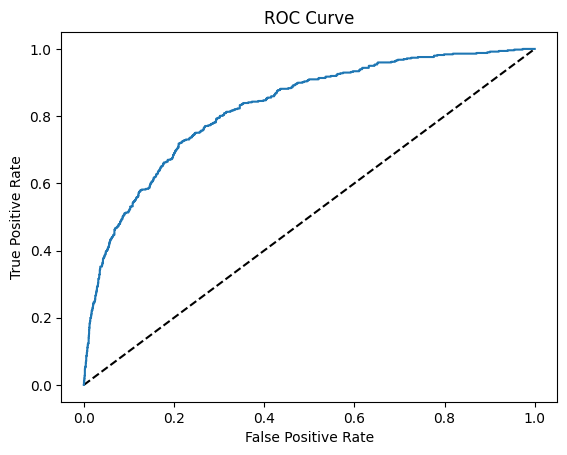

In [ ]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(train[TARGET],oof_lgb)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr,tpr,label='LogisticRegression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

7. 提出

In [1018]:
# submit_sample.csvを読み込みます。
submit = pd.read_csv("/content/sample_submit.csv", header=None)
submit.head(1)

,0,1
0,3489,0.119451


In [1019]:
# テストデータを用いて予測します。
predict0 = models[0].predict(test)
predict1 = models[1].predict(test)
predict2 = models[2].predict(test)
predict = (predict0 + predict1 + predict2) / 3
submit[1] = predict

In [1020]:
# 提出
submit.to_csv("submission.csv", index=False, header=None)